In [1]:
import numpy as np
import pickle
import time
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator, experimental_Simulator
from tasks import memory_tasks_variable as mt
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
%matplotlib inline

In [2]:
from scipy.linalg import schur

def relu(x):
    return np.maximum(x,0)

def state_to_out(s,w):
    return relu(s).dot(w['W_out'].T) + w['b_out']

def run_trial_batch(data,w,sim):
    s = np.zeros([data[0].shape[1],data[0].shape[0],w['W_rec'].shape[0]])
    for kk in range(data[0].shape[0]):
        s[:,kk,:] = sim.run_trial(data[0][kk,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],w['W_rec'].shape[0]])
        
    return s

def convert_to_rank(array):
    temp = array.argsort()
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(len(array))
    return ranks

def demean(s):
    return s-np.mean(s,axis=0)

def plot_eig_dist(s,W):
    '''plot eigenvalues of Weff-I over time'''
    fig = plt.figure()
    t = s.shape[0]
    n = s.shape[1]
    evals = np.zeros([t,n])
    for ii in range(t):
        mask = s[ii,:]>0
        evals[ii,:] = np.linalg.eig(W*mask - np.eye(W.shape[0]))[0].real
        plt.plot(ii*np.ones(len(evals[ii,:])),evals[ii,:],'.',c=[.5,0,.5],alpha=.2)
    plt.plot(np.max(evals.T,axis=0),'k',linewidth=2,alpha=.5)
    plt.plot(np.min(evals.T,axis=0),'k',linewidth=2,alpha=.5)
    plt.xlabel('Time')
    plt.ylabel('Eigenvalues')
    return fig

def plot_by_max(state,norm=True,thresh=.001):
    fr = np.maximum(state,thresh)
    if norm:
#         fr = ((fr-np.mean(fr,axis=0))/np.std(fr,axis=0))
        fr = ((fr-np.min(fr,axis=0))/(1e-10+np.max(fr,axis=0)-np.min(fr,axis=0)))
    idx = np.argsort(np.argmax(fr,axis=0))
    plt.pcolormesh(fr[:,idx].T)
    plt.colorbar()
    plt.xlim([0,np.shape(fr)[0]])
  
def calc_norm(A):
    return np.sqrt(np.sum(A**2,axis=0))

def gen_angle(W,U):
    normW = calc_norm(W)
    normU = calc_norm(U)
    return np.arccos(np.clip((W.T.dot(U))/np.outer(normW,normU),-1.,1.))

def hopfield_energy(s,w_rec,b_rec=None):
    E = 0.
    for ii in range(w_rec.shape[0]):
        for jj in range(w_rec.shape[0]):
            E-= s[ii]*s[jj]*w_rec[ii,jj]
            
    #account for input/bias/context
    if b_rec is not None:
        E -= np.sum(s*b_rec)
            
    return E

def ols(X,Y,reg=0.):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    w = np.linalg.inv(X.T.dot(X) + reg*np.eye(X.shape[1])).dot(X.T).dot(Y)
    
    return w,X.dot(w)

def run_ols(X,w):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    
    return X.dot(w)
            
    

In [3]:
mem_gap_length = 200

'''network list:
        "tag
            Description"
        'mtv3'
            Original Network (Test Network to devise analyses)
        'mtv4'
            Replication of mtv3
            
        'mtv_prepotent0'
            Same as mtv3/4 with p(stim0) = .8
        'mtv_long0'
            same as mtv3/4 but trained with memgap=200 (compared to 40)
        'mtv_long1'
            same as mtv3/4 but trained with memgap=50-200 (compared to 40)
        'mtv_2stage'
            train 1million at 0 rec noise, than 1million at .1 rec_noise
        '''

tag = 'mtv_curriculum0' #'mtv0'
weights_path = '../weights/' + tag + '.npz'
trials_path = '../weights/' + tag + '_trials.npz'
params_path = '../weights/' + tag + '_params.p'
    
#task params
input_wait = 20
stim_dur = 10
out_gap = 10 #20
out_dur = 60

var_delay_length = 0
var_in_wait = 0
var_out_gap = 0
p_stimulus = [.5,.5]
second_in_scale = 1.  #Only one input period or two (e.g. mem saccade no distractor vs with distractor)
go_cue = True
task = 'xor'
name = 'xor_fixed'

#model params
n_in = 12 
N_rec = 200 
n_out = 2
#n_steps = 80 
tau = 100.0 #As double
dt = 10.0  #As double
dale_ratio = 0
rec_noise = 0.1
stim_noise = 0.01
batch_size = 128

#regularization
L2_firing_rate = 1.
L1_rec = 0.01
L1_in = 0.01
L1_out = 0.01

#train params
learning_rate = .0001 
training_iters = 300000
display_step = 20

# weights_path = '../weights/' + name + '_' + str(mem_gap_length) + '.npz'
#weights_path = None

tasks = ['xor','xnor','or','nor','and','nand','memory_saccade','memory_saccade_inv','direct_report','direct_report_inv']

params = mt.set_params(epochs=200, sample_size= batch_size, input_wait=input_wait, 
                    stim_dur=stim_dur, mem_gap=mem_gap_length, out_gap = out_gap, out_dur=out_dur, 
                    N_rec=N_rec, p_stimulus = p_stimulus, #n_out = n_out, n_in = n_in, 
                    var_delay_length=var_delay_length, go_cue = go_cue,
                    var_in_wait = var_in_wait, var_out_gap = var_out_gap,
                    rec_noise=rec_noise, stim_noise=stim_noise, 
                    dale_ratio=dale_ratio, dt=dt, tau=tau, task=task,
                    second_in_scale=second_in_scale,
                    L2_firing_rate=L2_firing_rate,L1_rec=L1_rec,L1_in=L1_in,L1_out=L1_out)

generator = mt.generate_train_trials(params)

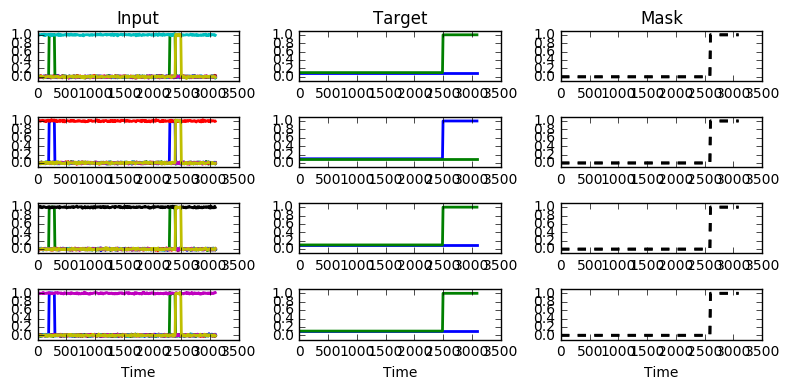

In [4]:
trial = mt.build_train_trials(params)
tt = np.arange(0,params['dt']*params['N_steps'],params['dt'])

plt.figure(figsize=(8,4))

for ii in range(4):
    plt.subplot(4,3,3*ii+1)
    plt.plot(tt,trial[0][ii,:,:],linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Input')
    
    plt.subplot(4,3,3*ii+2)
    plt.plot(tt,trial[1][ii,:,:],linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Target')
    
    plt.subplot(4,3,3*ii+3)
    plt.plot(tt,trial[2][ii,:,:],'k--',linewidth=2)
    plt.ylim([-.1,1.1])
    if ii == 3:
        plt.xlabel('Time')
    if ii == 0:
        plt.title('Mask')


plt.tight_layout()
plt.show()

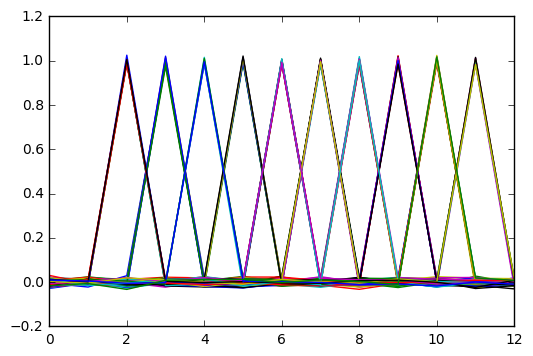

In [5]:
#rule inputs
plt.plot(trial[0][:,-1,:].T)
plt.show()

In [8]:
# # n_steps = input_wait + var_in_wait + stim_dur + mem_gap + var_delay_length + stim_dur + out_gap + var_out_gap + out_dur

# #first train 
# tf.reset_default_graph()
# # params['rec_noise'] = 0.0
# params['mem_gap'] = 40
# params['N_steps'] = input_wait + var_in_wait + stim_dur + params['mem_gap'] + var_delay_length + stim_dur + out_gap + var_out_gap + out_dur

# generator = mt.generate_train_trials(params)
# model = Model(params)

# sess = tf.Session()
# t = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
#             save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

# sess.close()

# #second train
# tf.reset_default_graph()
# params['load_weights_path'] = weights_path
# # params['rec_noise'] = 0.1
# params['mem_gap'] = 100
# params['N_steps'] = input_wait + var_in_wait + stim_dur + params['mem_gap'] + var_delay_length + stim_dur + out_gap + var_out_gap + out_dur


# generator = mt.generate_train_trials(params)


# model2 = Model(params)

# sess = tf.Session()
# t = model2.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
#              save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

# sess.close()



# #save train params
# #pickle.dump( params, open( params_path, "wb" ) )

In [8]:
#curriculum learning
if False:

    mem_gaps = range(40,210,20)

    params['load_weights_path'] = None
    training_iters = 500000


    #train loop
    for mem_gap in mem_gaps:
        print mem_gap
        tf.reset_default_graph()
        # params['rec_noise'] = 0.0
        params['mem_gap'] = mem_gap
        params['N_steps'] = input_wait + var_in_wait + stim_dur + params['mem_gap'] + var_delay_length + stim_dur + out_gap + var_out_gap + out_dur
        if mem_gap == 200:
            training_iters = 500000

        generator = mt.generate_train_trials(params)
        model = Model(params)

        sess = tf.Session()
        t = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
                    save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

        sess.close()

        params['load_weights_path'] = weights_path
        training_iters = 100000


    #save train params
    pickle.dump( params, open( params_path, "wb" ) )

40
Iter 2560, Minibatch Loss= 0.137755
Iter 5120, Minibatch Loss= 0.101508
Iter 7680, Minibatch Loss= 0.094916
Iter 10240, Minibatch Loss= 0.091732
Iter 12800, Minibatch Loss= 0.088050
Iter 15360, Minibatch Loss= 0.083112
Iter 17920, Minibatch Loss= 0.085799
Iter 20480, Minibatch Loss= 0.081952
Iter 23040, Minibatch Loss= 0.082724
Iter 25600, Minibatch Loss= 0.078347
Iter 28160, Minibatch Loss= 0.079000
Iter 30720, Minibatch Loss= 0.078012
Iter 33280, Minibatch Loss= 0.080850
Iter 35840, Minibatch Loss= 0.073157
Iter 38400, Minibatch Loss= 0.074609
Iter 40960, Minibatch Loss= 0.077964
Iter 43520, Minibatch Loss= 0.077619
Iter 46080, Minibatch Loss= 0.079322
Iter 48640, Minibatch Loss= 0.078445
Iter 51200, Minibatch Loss= 0.082766
Iter 53760, Minibatch Loss= 0.075950
Iter 56320, Minibatch Loss= 0.076907
Iter 58880, Minibatch Loss= 0.074623
Iter 61440, Minibatch Loss= 0.075486
Iter 64000, Minibatch Loss= 0.078520
Iter 66560, Minibatch Loss= 0.071485
Iter 69120, Minibatch Loss= 0.074061
I

../weights/mtv_curriculum0.npz


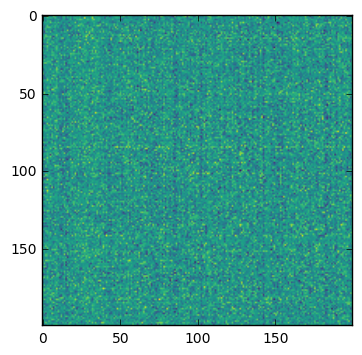

In [6]:
#save train params
# pickle.dump( params, open( params_path, "wb" ) )
# weights_path = '../weights/cbdc_curric5_bff_200_0.npz'
print weights_path
w = np.load(weights_path)

plt.imshow(w['W_rec'])
plt.show()

In [7]:
#run trials test

weights_path = '../weights/cbdc_curric3_gauss_200_1.npz'

w = np.load(weights_path)

# w['input_connectivity'] = 1.
# w['output_connectivity'] = 1.
# w['rec_connectivity'] = 1.

# #test params

mem_gap_length = 200

params['sample_size'] = 1000
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['mem_gap'] = mem_gap_length #40
params['p_stimulus'] = [.5,.5]
params['var_delay_length'] = 0

# params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
#                     stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
#                     L2_firing_rate = 0, sample_size = sample_size, epochs = 100, N_rec = n_hidden, 
#                     dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = mt.generate_train_trials(params)

sim = Simulator(params, weights_path=weights_path)

data = generator.next()


tt = np.arange(0,params['dt']*data[0].shape[1],params['dt'])
# data[0][:,40:,2:7] = 0.

s = run_trial_batch(data,w,sim)

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)
    
    
in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

rule = np.argmax(data[0][:,0,2:len(tasks)+2],axis=1)
choice = np.argmax(o[-1,:,:],axis=1)
target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
correct = choice == target

print 'performance = ' + str(np.mean(correct)*100) + '%'

tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
n_tasks = len(tasks)

for ii in range(n_tasks):
    
    print tasks[ii] + ' performance = ' + str(100*np.mean(choice[rule==ii]==target[rule==ii])) + '%'

performance = 99.2%
xor performance = 98.9795918367%
xnor performance = 99.1304347826%
or performance = 100.0%
nor performance = 100.0%
and performance = 98.9361702128%
nand performance = 98.8764044944%
memory performance = 100.0%
memory_inv performance = 96.9072164948%
report performance = 100.0%
report_inv performance = 98.8505747126%


/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: invalid value encountered in log


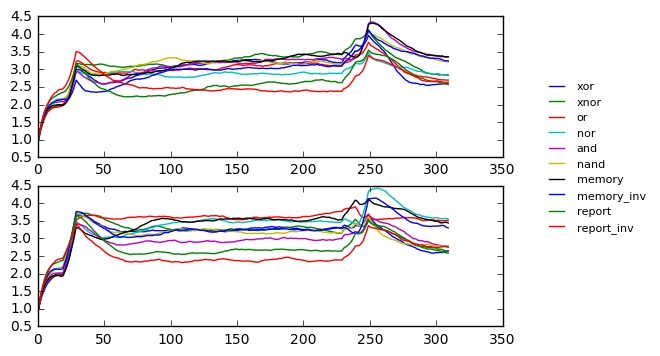

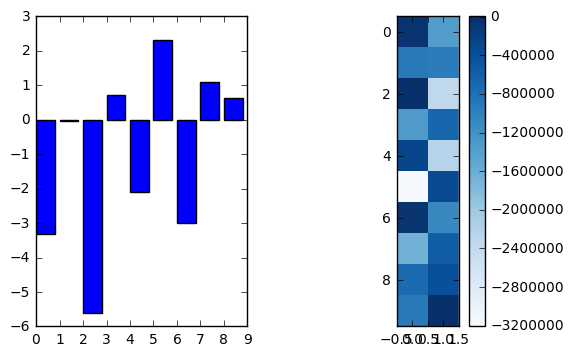

In [20]:
#first order approximation to minimum control energy Kim et al. 2017 (Bassett)

t0 = 200

plt.figure()
cE = np.zeros([n_tasks,2])
for r_id in range(n_tasks):
    for i_id in range(2):
        
        plt.subplot(2,1,i_id+1)
        mean_fr = np.mean(relu(s[:,np.logical_and(in1==i_id,rule==r_id),:]),axis=1)
        mean_s = np.mean(s[:,np.logical_and(in1==i_id,rule==r_id),:],axis=1)
        
        plt.plot(np.sqrt(np.sum((mean_s)**2,axis=1)))

        xd = np.mean(s[t0,np.logical_and(in1==i_id,rule==r_id),:100],axis=0).reshape([100,1])
        xnd = np.mean(s[t0,np.logical_and(in1==i_id,rule==r_id),100:],axis=0).reshape([100,1])

        w21 = w['W_rec'][100:,:100]

        cE[r_id,i_id] = 12*(xnd-.5*w21.dot(xd)).T.dot(np.linalg.inv(w21.dot(w21.T))).dot((xnd-.5*w21.dot(xd))) + xd.T.dot(xd)
        
plt.legend(tasks,fontsize=8,frameon=False,loc='center',bbox_to_anchor=[1.2,1.2,0,0])    

plt.figure()
plt.subplot(1,2,2)
plt.imshow(cE,cmap='Blues',interpolation='none')
plt.colorbar()
plt.subplot(1,2,1)
plt.bar(range(10),np.log(cE[:,0]/cE[:,1]))
plt.show()

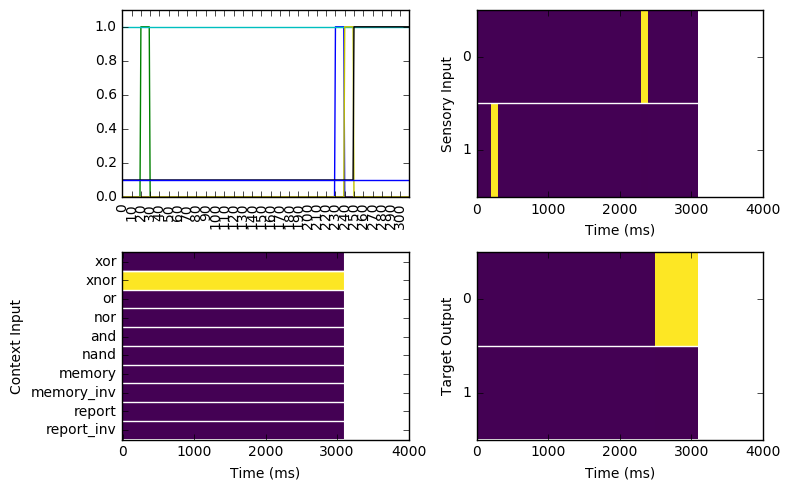

In [22]:
plt.figure(figsize=(8,5))

trial = 1

plt.subplot(2,2,1)
plt.xticks(np.arange(0,350,10),rotation=90)
plt.plot(data[0][trial,:,:])
plt.plot(data[1][trial,:,:])
plt.ylim([0,1.1])

plt.subplot(2,2,2)
plt.imshow(data[0][trial,:,:2].T,aspect='auto',interpolation='none')
plt.axhline(.5,c='w')
plt.yticks([0,1],[0,1])
plt.xticks(np.arange(0,401,100),(dt*np.arange(0,401,100)).astype('int'))
plt.xlabel('Time (ms)')
plt.ylabel('Sensory Input')


plt.subplot(2,2,3)
plt.imshow(data[0][trial,:,2:-1].T,aspect='auto',interpolation='none')
plt.axhline(.5,c='w')
plt.yticks(range(10),tasks)
for ii in range(10):
    plt.axhline(.5+ii,c='w')
plt.xticks(np.arange(0,401,100),(dt*np.arange(0,401,100)).astype('int'))
plt.xlabel('Time (ms)')
plt.ylabel('Context Input')

plt.subplot(2,2,4)
plt.imshow(data[1][trial,:,:].T,aspect='auto',interpolation='none')
plt.axhline(.5,c='w')
plt.yticks([0,1],[0,1])
plt.xticks(np.arange(0,401,100),(dt*np.arange(0,401,100)).astype('int'))
plt.xlabel('Time (ms)')
plt.ylabel('Target Output')


plt.tight_layout()
plt.show()

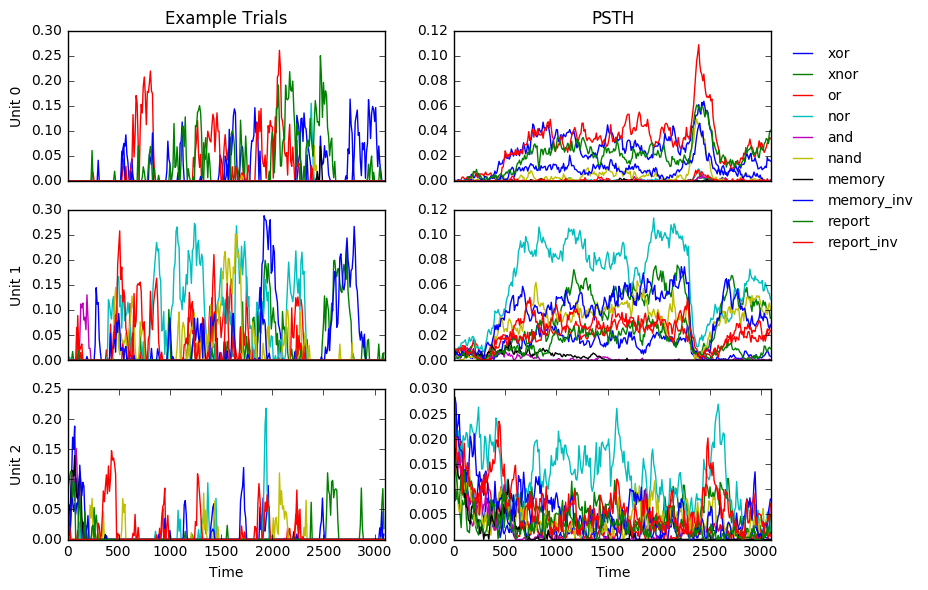

In [23]:
#example neurons

plt.figure(figsize=(8,6))
for jj in range(3):
    plt.subplot(3,2,2*jj+1)
    for ii in range(n_tasks):
        plt.plot(tt,relu(s[:,np.where(np.logical_and(rule==ii,in1==0))[0][0],jj+5]))
        plt.xlim([0,dt*len(tt)])
        plt.ylabel('Unit {}'.format(jj))
    if jj ==0:
        plt.title('Example Trials'.format(jj)  )
    if jj == 2:
        plt.xlabel('Time')
    if jj<2: 
        plt.xticks([])
        
#     if jj == 2:
#         plt.legend(tasks,fontsize=6,loc='center',bbox_to_anchor=[1.25,2.6,0,0],frameon=False)
   
for jj in range(3):
    plt.subplot(3,2,2*jj+2)
    for ii in range(n_tasks):
        plt.plot(tt,np.mean(relu(s[:,np.where(np.logical_and(rule==ii,in1==0))[0],jj+5]),axis=1))
        plt.xlim([0,dt*len(tt)])
    if jj == 0:
        plt.title('PSTH')
    if jj == 2:
        plt.legend(tasks,fontsize=10,loc='center',bbox_to_anchor=[1.25,2.6,0,0],frameon=False)
        plt.xlabel('Time')
    if jj<2: 
        plt.xticks([])

plt.tight_layout()
plt.show()

# s.shape

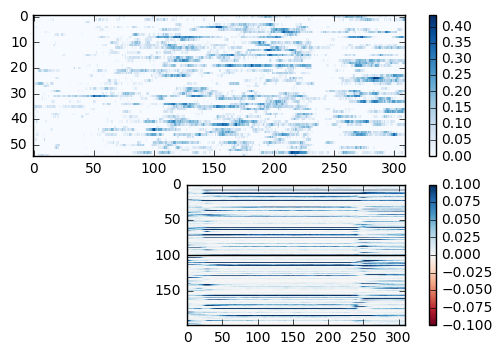

In [24]:
r = 1

plt.subplot(2,1,1)
# plt.imshow(np.mean(relu(s[:,np.logical_and(rule==r,in1==0),:]),axis=1).T,vmin=-.1,vmax=.1,cmap='RdBu')
# plt.axhline(100,color='k')
plt.imshow(relu(s[:,np.logical_and(rule==r,in1==0),6].T),cmap='Blues',vmin=0,aspect='auto',interpolation='none')
plt.colorbar()

plt.subplot(2,1,2)
plt.imshow(np.mean(relu(s[:,np.logical_and(rule==r,in1==1),:]),axis=1).T,vmin=-.1,vmax=.1,cmap='RdBu')
plt.axhline(100,color='k')
plt.colorbar()
plt.show()

In [25]:
#Caculate Hopfield Energy (Conflict) by time/task/in1
hop_en = False
if hop_en:
    hE = np.zeros([s.shape[0],n_tasks,2])
    for ii in range(s.shape[0]):
        for jj in range(n_tasks):
            for kk in range(2):
                idx = np.logical_and(rule==jj,in1==kk)
                context = w['W_in'][:,jj+2]
                hE[ii,jj,kk] = hopfield_energy(np.mean(relu(s[ii,idx,:]),axis=0),w['W_rec'],b_rec=w['b_rec']+context)

In [26]:
#plot
if hop_en:
    colors = ['r','g','b','k','y','c','m','r--','g--','b--','k--','']*10

    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.title('in1=0')
    for ii in range(n_tasks):
        plt.plot(tt,hE[:,ii,0],colors[ii])
    plt.ylabel('Hopfield Energy')
    plt.xlabel('Time')

    plt.subplot(1,2,2)
    plt.title('in1=1')
    for ii in range(n_tasks):
        plt.plot(tt,hE[:,ii,1],colors[ii])
    # plt.ylabel('Hopfield Energy')
    plt.xlabel('Time')
    plt.legend(tasks,fontsize=8,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()

In [27]:
if hop_en:
    plt.bar(range(0,20,2),np.mean(hE[100:200,:,0],axis=0))
    plt.bar(range(1,21,2),np.mean(hE[100:200,:,1],axis=0),color='c')
    plt.xticks(np.arange(1,20.5,2),tasks,rotation=45)
    plt.ylabel('Hopfield Energy')
    plt.legend(['In1=0','In1=1'],loc='center',bbox_to_anchor=[1.25,.8,0,0])
    plt.show()

In [28]:
if hop_en:
    for ii in range(n_tasks):
        plt.plot(tt,hE[:,ii,1]-hE[:,ii,0],colors[ii])
    plt.ylabel('Hopfield Energy')
    plt.xlabel('Time')
    plt.legend(tasks,fontsize=8,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.show()

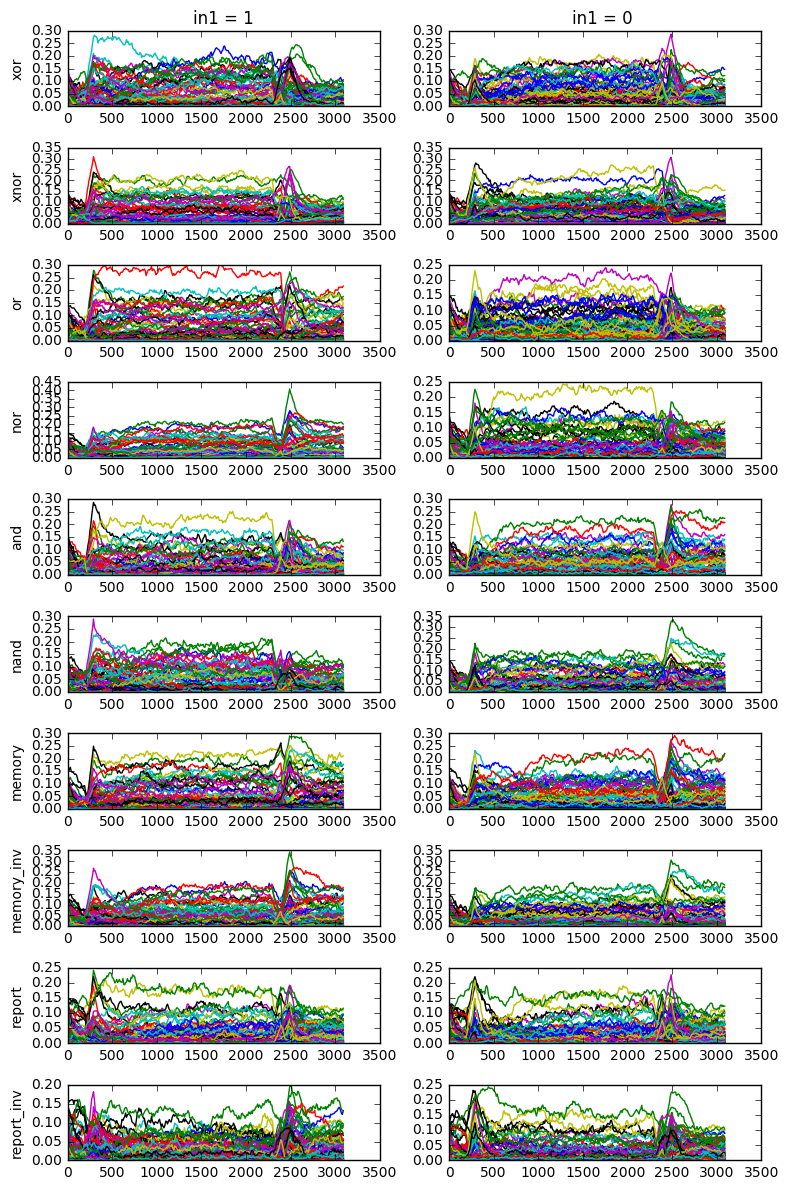

In [29]:
#firing rates as a function of in1

in11_fr = np.zeros([s.shape[0],s.shape[2],len(tasks)])
in10_fr = np.zeros([s.shape[0],s.shape[2],len(tasks)])

plt.figure(figsize=(8,12))
for ii in range(len(tasks)):
    plt.subplot(len(tasks),2,2*ii+1)
    if ii ==0:
        plt.title('in1 = 1')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
    plt.ylabel(tasks[ii])
    in11_fr[:,:,ii] = np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1)
    
# plt.figure(figsize=(8,12))
for ii in range(len(tasks)):
    plt.subplot(len(tasks),2,2*ii+2)
    if ii ==0:
        plt.title('in1 = 0 ')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==0),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
#     plt.ylabel(tasks[ii])
    in10_fr[:,:,ii] = np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==0),:],0),axis=1)
    
plt.tight_layout()
plt.show()

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


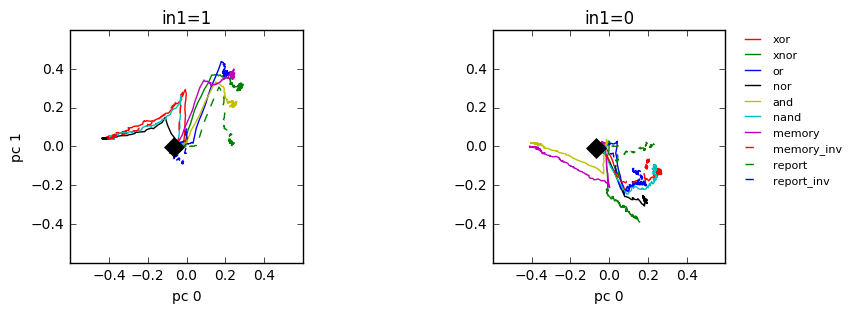

In [30]:
fr_all = np.hstack([in10_fr[200,:,:],in11_fr[200,:,:]])

pcs_rule = np.linalg.eig(np.cov(demean(fr_all)))[1]

colors = ['r','g','b','k','y','c','m','r--','g--','b--','k--','']*10

component = [0,1]

plt.figure(figsize=(10,3))
for ii in range(n_tasks):
    plt.subplot(1,2,1)
    plt.title('in1=1')
    plt.ylabel('pc ' + str(component[1]))
    plt.xlabel('pc ' + str(component[0]))
    plt.plot(in11_fr[:200,:,ii].dot(pcs_rule[:,component[0]]),in11_fr[:200,:,ii].dot(pcs_rule[:,component[1]]),colors[ii])
#     plt.plot(in11_fr[30,:,ii].dot(pcs_rule[:,component]),in11_fr[30,:,ii].dot(pcs_rule[:,1]),colors[ii]+'o')
    plt.subplot(1,2,2)
    plt.title('in1=0')
    plt.xlabel('pc ' + str(component[0]))
    plt.plot(in10_fr[:200,:,ii].dot(pcs_rule[:,component[0]]),in10_fr[:200,:,ii].dot(pcs_rule[:,component[1]]),colors[ii])
#     plt.plot(in10_fr[30,:,ii].dot(pcs_rule[:,component]),in10_fr[30,:,ii].dot(pcs_rule[:,1]),colors[ii]+'o')
    
plt.legend(tasks,fontsize=8,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax = plt.subplot(1,2,1)    
plt.plot(in11_fr[0,:,ii].dot(pcs_rule[:,component[0]]),in11_fr[0,:,ii].dot(pcs_rule[:,component[1]]),'kD',markersize=10)
plt.ylim([-.6,.6])
plt.xlim([-.6,.6])
ax.set_aspect('equal')
ax = plt.subplot(1,2,2)    
plt.plot(in10_fr[0,:,ii].dot(pcs_rule[:,component[0]]),in10_fr[0,:,ii].dot(pcs_rule[:,component[1]]),'kD',markersize=10)
plt.ylim([-.6,.6])
plt.xlim([-.6,.6])
ax.set_aspect('equal')
plt.subplot(1,2,2)   


plt.show()


/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


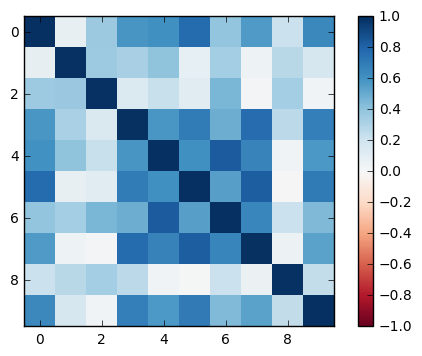

In [31]:
pcs_rule = np.zeros([N_rec,N_rec,n_tasks])
for ii in range(n_tasks):
    evals, pcs_rule[:,:,ii] = np.linalg.eig(np.cov(demean(relu(s[200,rule==ii,:].T))))
#     print np.max(evals.imag)
#     print np.argmax(evals.real)

plt.imshow(np.abs(np.corrcoef(pcs_rule[:,0,:].T)),interpolation='none',cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()
plt.show()

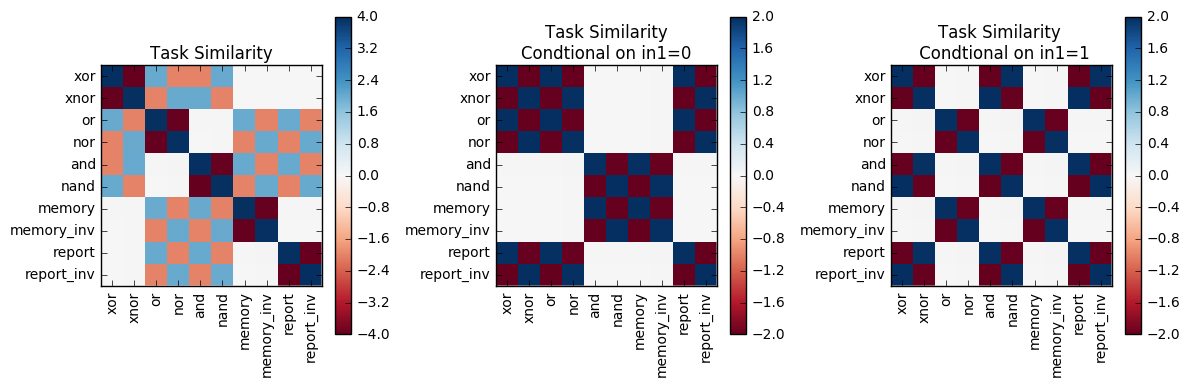

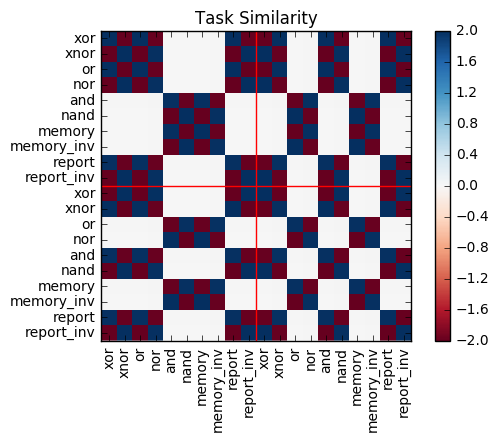

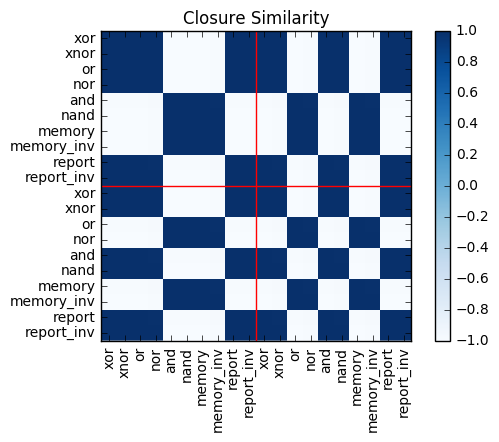

In [32]:
#condition [0,0],[0,1],[1,0],[1,1]
response_matrix = 1-2*np.array([[0,1,1,0],
                                [1,0,0,1],
                                [0,1,1,1],
                                [1,0,0,0],
                                [0,0,0,1],
                                [1,1,1,0],
                                [0,0,1,1],
                                [1,1,0,0],
                                [0,1,0,1],
                                [1,0,1,0]])

closure_matrix = np.array([[0,0],[0,0],[0,1],[0,1],[1,0],[1,0],[1,1],[1,1],[0,0],[0,0]])
closure_vec = 1-2*np.vstack([closure_matrix[:,0:1],closure_matrix[:,1:2]])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Task Similarity')
plt.imshow(response_matrix.dot(response_matrix.T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(10),tasks)
plt.xticks(range(10),tasks,rotation='vertical')
plt.subplot(1,3,2)
plt.title('Task Similarity\nCondtional on in1=0')
plt.imshow(response_matrix[:,:2].dot(response_matrix[:,:2].T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(10),tasks)
plt.xticks(range(10),tasks,rotation='vertical')
plt.subplot(1,3,3)
plt.title('Task Similarity \n Condtional on in1=1')
plt.imshow(response_matrix[:,2:].dot(response_matrix[:,2:].T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(10),tasks)
plt.xticks(range(10),tasks,rotation='vertical')

plt.tight_layout()

all_resp_mat = np.vstack([response_matrix[:,:2],response_matrix[:,2:]])

plt.figure()
plt.title('Task Similarity')
plt.imshow(all_resp_mat.dot(all_resp_mat.T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')

# plt.figure()
# # ax = plt.gca()
# # clust_data = np.random.random((10,3))
# # collabel=("0-0", "0-1", "1-0","1-1")
# # ax.axis('tight')
# # ax.axis('off')
# # the_table = ax.table(cellText=response_matrix,colLabels=collabel,loc='center')

# plt.imshow(response_matrix,interpolation='none',cmap='Blues')

plt.figure()
plt.title('Closure Similarity')
plt.imshow(closure_vec.dot(closure_vec.T),interpolation='none',cmap='Blues')
plt.colorbar()
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')

plt.show()



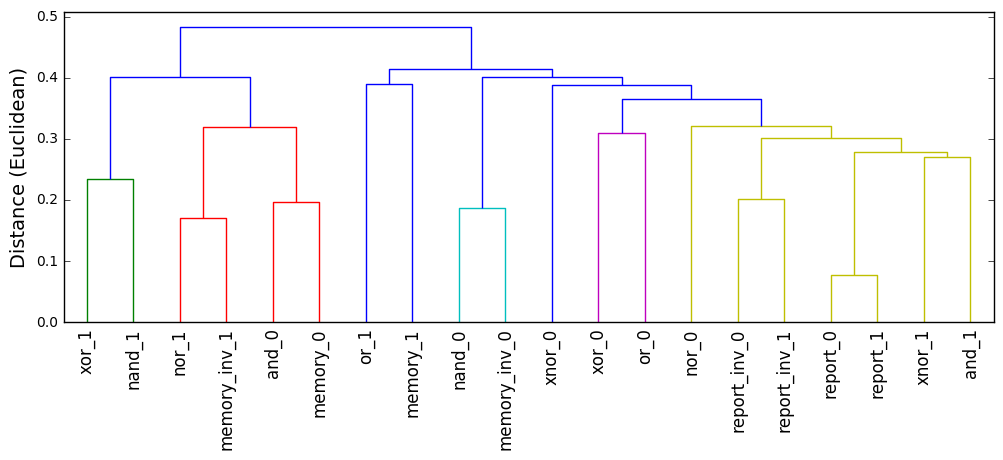

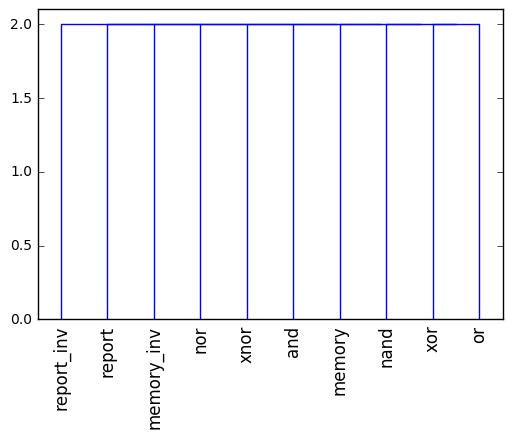

In [33]:
from scipy.cluster import hierarchy
plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
ytdist = pdist(fr_all.T,metric='euclidean')
Z = hierarchy.linkage(ytdist, 'single')
dn = hierarchy.dendrogram(Z,labels=[t_+'_0' for t_ in tasks]+[t_+'_1' for t_ in tasks],leaf_rotation=90)
plt.ylabel('Distance (Euclidean)',fontsize=14)

plt.figure()
ytdist = pdist(response_matrix)
# ytdist = pdist(all_resp_mat)
Z = hierarchy.linkage(ytdist, 'single')

dn = hierarchy.dendrogram(Z,labels=tasks,leaf_rotation=90)

plt.show()
# squareform(pdist(response_matrix))

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:583: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


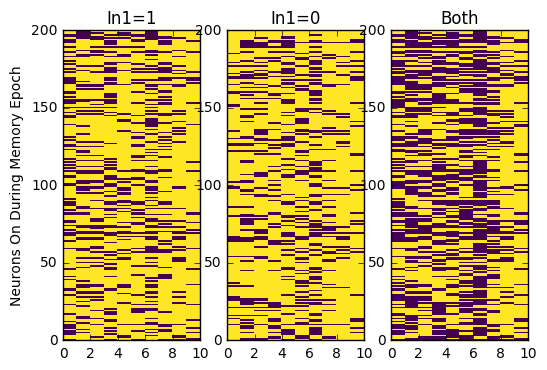

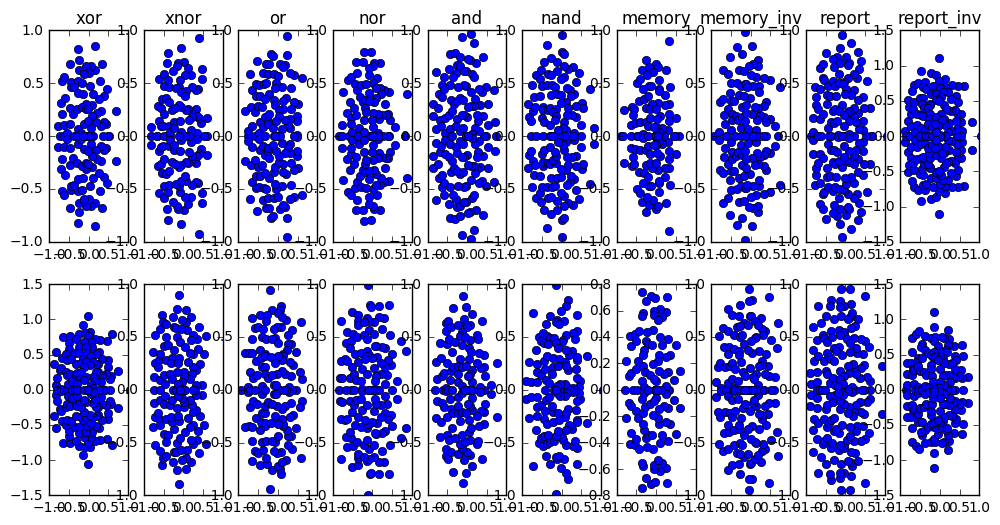

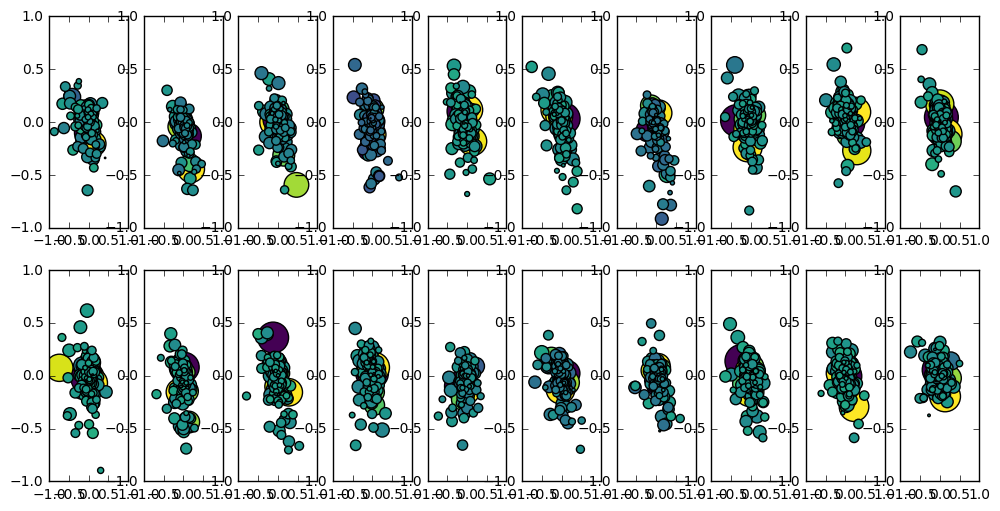

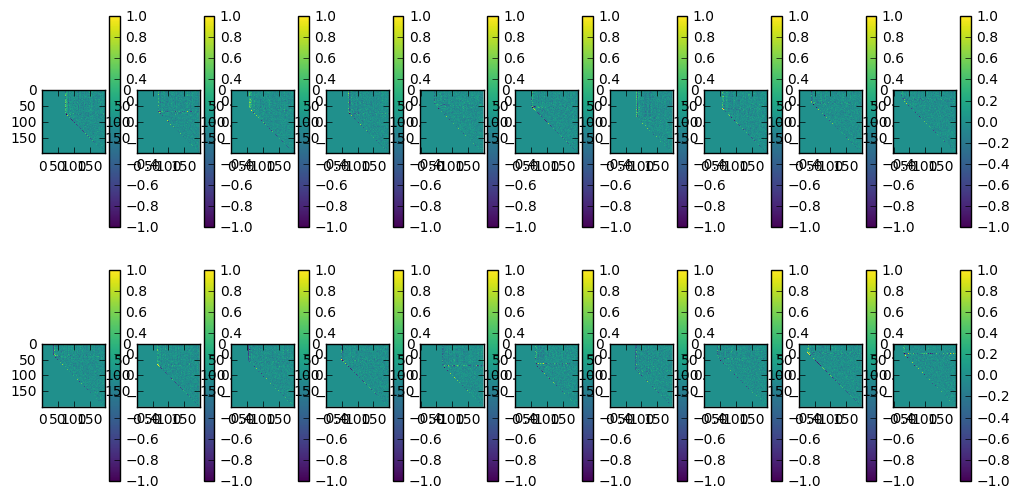

In [34]:
mask_in11 = in11_fr[200,:,:]>0
mask_in10 = in10_fr[200,:,:]>0

# mask_in11 = in11_fr[-1,:,:]>0
# mask_in10 = in10_fr[-1,:,:]>0

fr_all = np.hstack([in10_fr[200,:,:],in11_fr[200,:,:]])

#partitions during memory epoch by condition and input
plt.figure()
plt.subplot(1,3,1)
plt.pcolor(mask_in11)
plt.ylabel('Neurons On During Memory Epoch')
plt.title('In1=1')
plt.subplot(1,3,2)
plt.pcolor(mask_in10)
plt.title('In1=0')
plt.subplot(1,3,3)
plt.pcolor(np.logical_and(mask_in10,mask_in11))
plt.title('Both')


#Eigenspectra by condition and input
plt.figure(figsize=(12,6))
for ii in range(len(tasks)):
    plt.subplot(2,len(tasks),ii+1)
    plt.title(tasks[ii])
    plt.plot(np.linalg.eig(w['W_rec']*mask_in11[:,ii])[0].real,np.linalg.eig(w['W_rec']*mask_in11[:,ii])[0].imag,'o')
    plt.xlim([-1,1])
    plt.subplot(2,len(tasks),ii+len(tasks)+1)
    plt.plot(np.linalg.eig(w['W_rec']*mask_in10[:,ii])[0].real,np.linalg.eig(w['W_rec']*mask_in10[:,ii])[0].imag,'o')
    plt.xlim([-1,1])

#projection onto eigenbasis (colored by eigenvalue) by condition and input
plt.figure(figsize=(12,6))
for ii in range(len(tasks)):
    evals,evecs = np.linalg.eig(w['W_rec']*mask_in11[:,ii])
    plt.subplot(2,len(tasks),ii+1)
    plt.scatter(evecs.dot(w['W_in'][:,0:1]),evecs.dot(w['W_in'][:,1:2]),s=100*np.abs(evals),c=evals)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    
#     print evecs[:,np.argmax(evals.real)].T.dot(w['W_in'][:,0:2]).real
    
    evals,evecs = np.linalg.eig(w['W_rec']*mask_in10[:,ii])
    plt.subplot(2,len(tasks),ii+len(tasks)+1)
    plt.scatter(evecs.dot(w['W_in'][:,0:1]),evecs.dot(w['W_in'][:,1:2]),s=100*np.abs(evals),c=evals)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    
#     print evecs.T.dot(w['W_in'][:,0:2])[np.argmax(evals.real),:].real
    
#     print ''

#schur decompositions by condition and input
plt.figure(figsize=(12,6))
for ii in range(len(tasks)):
    ax = plt.subplot(2,len(tasks),ii+1)
    plt.imshow(schur(w['W_rec']*mask_in11[:,ii])[0],interpolation='none',vmin=-1,vmax=1)
    plt.colorbar()
    ax = plt.subplot(2,len(tasks),ii+len(tasks)+1)
    plt.imshow(schur(w['W_rec']*mask_in10[:,ii])[0],interpolation='none',vmin=-1,vmax=1)
    plt.colorbar()
    

plt.show()


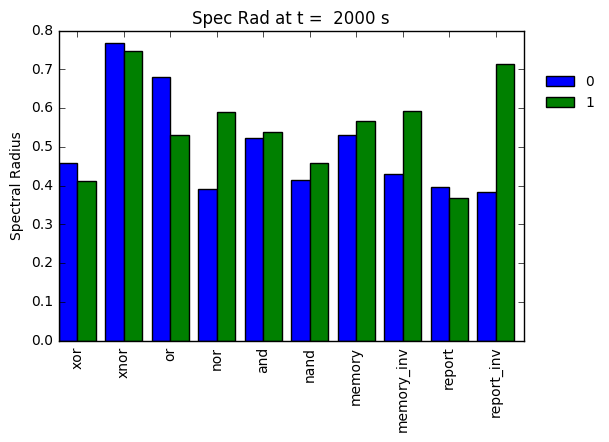

In [35]:
#data tensor form
s_tensor = np.zeros([s.shape[0],s.shape[2],2,n_tasks])

for ii in range(2):
    for jj in range(n_tasks):
        s_tensor[:,:,ii,jj] = np.mean(s[:,np.logical_and(in1==ii,rule==jj),:],axis=1)

#spectral radius by input1 and task
t0 = 200
spec_rad = np.zeros([n_tasks,2])
for ii in range(len(tasks)):
    
    evals,evecs = np.linalg.eig(w['W_rec']*(s_tensor[t0,:,0,ii]>0.))
    spec_rad[ii,0] = np.max(np.abs(evals))
    
    evals,evecs = np.linalg.eig(w['W_rec']*(s_tensor[t0,:,1,ii]>0.))
    spec_rad[ii,1] = np.max(np.abs(evals))
    
    
plt.figure()
plt.bar(np.arange(10),spec_rad[:,0],width=.4,color='b')
plt.bar(.4+np.arange(10),spec_rad[:,1],width=.4,color='g')
plt.legend(['0','1'],fontsize=10,frameon=False,loc='center',bbox_to_anchor=[1.1,.8,0,0])
plt.xticks(.4+np.arange(10),tasks,rotation=90)
plt.ylabel('Spectral Radius')
plt.title('Spec Rad at t =  {} s'.format(int(t0*dt)))
    
plt.show()

In [ ]:
import tensorly as tly
from tensorly.decomposition import parafac, tucker

tens = tly.tensor(relu(s_tensor[0:310:10,:,:]))

factors = parafac(tens,rank=3)

a_hat = tly.backend.to_numpy(factors[0])
b_hat = tly.backend.to_numpy(factors[1])
c_hat = tly.backend.to_numpy(factors[2])
d_hat = tly.backend.to_numpy(factors[3])

# for ii in range(10):
#     plt.figure()
#     plt.imshow(b_hat[:,ii].reshape(2,1).dot(c_hat[:,ii].reshape(1,10)),interpolation='none',cmap='RdBu',vmin=-.5,vmax=.5)
plt.imshow(a_hat,interpolation='none',cmap='RdBu',vmin=-1,vmax=1,aspect='auto')

# plt.colorbar()
plt.show()


Using mxnet backend.


In [36]:
plt.plot(a_hat)
# plt.colorbar()
plt.show()

s_tensor.shape

NameError: name 'a_hat' is not defined

xor 10
xnor 14
or 13
nor 10
and 18
nand 26
memory 30
memory_inv 10
report 10
report_inv 12


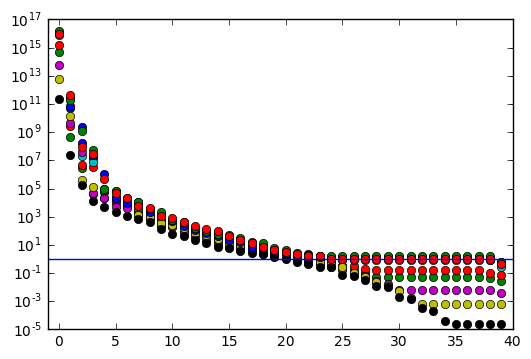

In [50]:
#controllability

for jj in range(n_tasks):
    w_stim = w['W_in'][:,:2]
    w_eff = w['W_rec']*mask_in10[:,jj] - np.eye(200)
    
#     print np.max(np.linalg.eig(w_eff)[0].real)

    kalm = np.hstack([w_stim]+[np.linalg.matrix_power(w_eff,ii).dot(w_stim) for ii in range(1,20)] )
    print tasks[jj], np.linalg.matrix_rank(kalm)
    S = np.linalg.svd(kalm)[1]
    plt.semilogy(S,'o')

kalm = np.hstack([w_stim]+[np.linalg.matrix_power(w_eff,ii).dot(w_stim) for ii in range(1,200)] )

# plt.imshow(kalm,cmap='RdBu',vmin=-10.5,vmax=10.5,aspect='auto')
# plt.xlim([0,20])
# plt.colorbar()
plt.axhline(1)
plt.xlim(-1,40)
plt.show()

In [38]:
kalm = np.hstack([np.linalg.matrix_power(w_eff,ii).dot(w_stim) for ii in range(0,100)])

X = kalm[:,:80]
S = np.linalg.svd(X)[1]

eps = 4e-15

print np.sum(S>X.max()*max(X.shape)*eps)
print np.linalg.matrix_rank(X)

X.shape

# np.hstack([np.linalg.matrix_power(w_eff,ii).dot(w_stim) for ii in range(0,30)]).shape

2
2


(200, 80)

In [ ]:
#projection of state onto axes

plt.figure(figsize=(12,10))

t0 = 200
t1 = 260

axis0 = w['W_in'][:,0:1]
axis1 = w['W_in'][:,1:2]

for ii in range(n_tasks):
    ax = plt.subplot(3,4,ii+1)
    
    i00 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],0),axis=1)
    i01 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],0),axis=1)
    i10 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],0),axis=1)
    i11 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],0),axis=1)
    
    plt.plot(i00[t0:t1,:].dot(axis0),i00[t0:t1,:].dot(axis1),'c')
    plt.plot(i01[t0:t1,:].dot(axis0),i01[t0:t1,:].dot(axis1),'m')
    
    plt.plot(i10[t0:t1,:].dot(axis0),i00[t0:t1,:].dot(axis1),'c--')
    plt.plot(i11[t0:t1,:].dot(axis0),i01[t0:t1,:].dot(axis1),'m--')
    
    
#     plt.xlim([-1.5,1.5])
#     plt.ylim([-1.5,1.5])
    plt.plot([-1,1],[-1,1],'k--')
    ax.set_aspect('equal')
    plt.grid('on')
    plt.title(tasks[ii])

plt.legend(['in1=0','in1=1'],fontsize=8,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

# in10_fr.shape

In [ ]:
#projection of state onto axes

plt.figure(figsize=(12,10))

t0 = 230#150

# t1 = -1

n_examples = 1

c_choice,_ = ols(s[t0,:,:],choice,reg=10.)
c_in1,_ = ols(s[t0,:,:],in1,reg=10.)



c_0 = c_in1
c_1 = c_choice

for ii in range(n_tasks):
    ax = plt.subplot(3,4,ii+1)
    
    
    i00_0 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],c_0)
    i01_0 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],c_0)
    i10_0 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],c_0)
    i11_0 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],c_0)
    
    i00_1 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],c_1)
    i01_1 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],c_1)
    i10_1 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],c_1)
    i11_1 = run_ols(s[t0,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],c_1)

    plt.plot(i00_0,i00_1,'co')
    plt.plot(i01_0,i01_1,'mo')

    plt.plot(i10_0,i10_1,'cx')
    plt.plot(i11_0,i11_1,'mx')
    
    
    plt.xlim([-.5,1.5])
    plt.ylim([-.5,1.5])
#     plt.plot([-1,1],[-1,1],'k--')
    ax.set_aspect('equal')
    plt.grid('on')
    plt.title(tasks[ii])

plt.legend(['00','01','10','11'],fontsize=8,frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

# in10_fr.shape

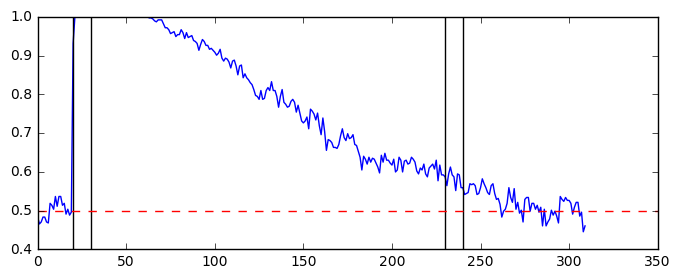

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [527]:
#linear classifier over time

idx = rule<8 #np.logical_or(rule==3,rule==4)
split = int(np.sum(idx)/2.)

target = in1

# plt.subplot(2,1,1)
acc =  np.zeros(s.shape[0])
for tt in range(s.shape[0]):
    c,_ = ols(s[tt,idx,:][:split,:],target[idx][:split],reg=1.)
    y_hat = run_ols(s[tt,idx,:][split:,:],c)
    acc[tt] = np.mean((y_hat>.5).astype('int')== target[idx][split:])
    
#     plt.plot(tt*np.ones(y_hat.shape[0]),y_hat,'bo',alpha=.1)
  

plt.figure(figsize=(8,3))
plt.plot(acc)
plt.axvline(params['input_wait'],c='k')
plt.axvline(params['input_wait']+params['stim_dur'],c='k')

plt.axvline(params['input_wait']+params['stim_dur']+params['mem_gap'],c='k')
plt.axvline(params['input_wait']+2*params['stim_dur']+params['mem_gap'],c='k')

plt.axhline(.5,c='r',linestyle='--')
plt.show()

np.unique(rule)

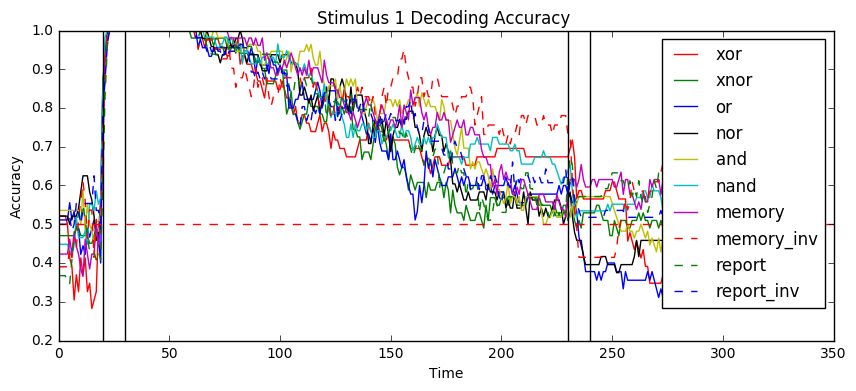

In [528]:
#linear classifier from timepoint t0

idxs = [rule==ii for ii in range(10)]
idx_names = tasks
plt.figure(figsize=(10,4))

count=0
for idx in idxs:
#     idx = rule<8 #np.logical_or(rule==3,rule==4)
    split = int(np.sum(idx)/2.)

    t0 = 50
    c,_ = ols(s[t0,idx,:][:split,:],target[idx][:split],reg=1.)

    target = in1

    # plt.subplot(2,1,1)
    acc =  np.zeros(s.shape[0])
    for tt in range(s.shape[0]):

        y_hat = run_ols(s[tt,idx,:][split:,:],c)
        acc[tt] = np.mean((y_hat>.5).astype('int')== target[idx][split:])

    #     plt.plot(tt*np.ones(y_hat.shape[0]),y_hat,'bo',alpha=.1)


    
    plt.plot(acc,colors[count])
    count+=1
    
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Stimulus 1 Decoding Accuracy ')

plt.axvline(params['input_wait'],c='k')
plt.axvline(params['input_wait']+params['stim_dur'],c='k')

plt.axvline(params['input_wait']+params['stim_dur']+params['mem_gap'],c='k')
plt.axvline(params['input_wait']+2*params['stim_dur']+params['mem_gap'],c='k')

plt.axhline(.5,c='r',linestyle='--')

plt.legend(idx_names)

plt.show()

In [525]:
# target = in1

def norm(v):
    return v/np.sqrt(np.sum(v**2))

def get_angle(v,w):
    return np.arccos(np.clip(np.dot(norm(v), norm(w)), -1.0, 1.0))
                     
t0=200
idx = rule<10

c_in1,_ = ols(s[t0,idx,:][:split,:],in1[idx][:split],reg=1)
c_choice,_ = ols(s[t0,idx,:][:split,:],choice[idx][:split],reg=1)

print 'angle between choice axis and in1 axis = {} rad'.format(np.round(get_angle(c_in1,c_choice),decimals=2))


angle between choice axis and in1 axis = 1.36 rad


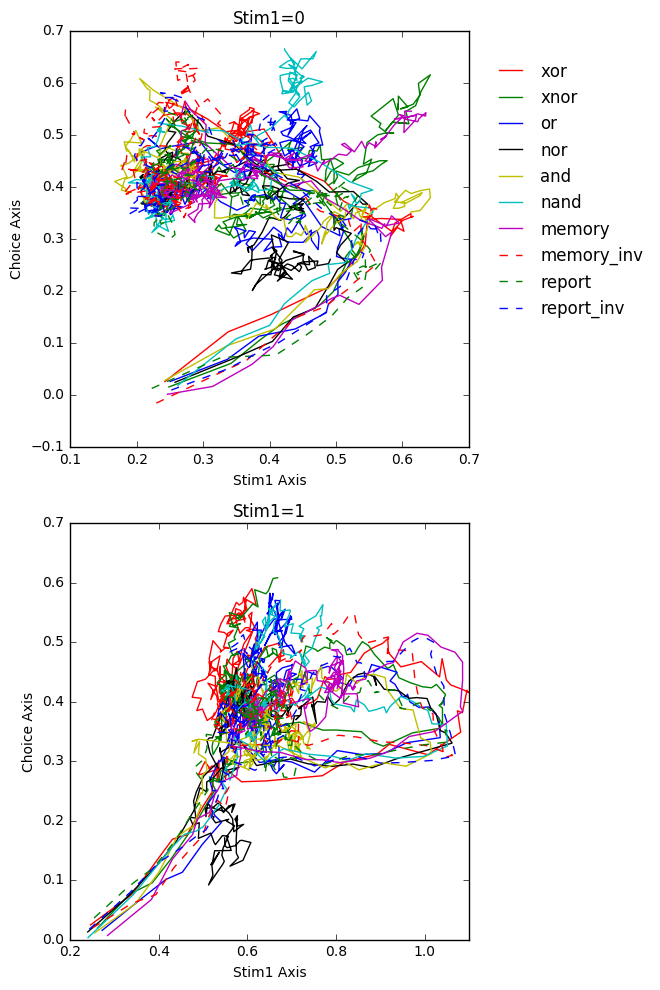

In [526]:
#(same as above but to plot y_hat)linear classifier from timepoint t0

idxs = [rule==ii for ii in range(10)]
idx_names = tasks
plt.figure(figsize=(5,10))

idx = rule<10
t0 = 200
target = in1
# c,_ = ols(s[t0,idx,:][:split,:],target[idx][:split],reg=1)

count=0
for idx in idxs:
#     idx = rule<8 #np.logical_or(rule==3,rule==4)
    split = int(np.sum(idx)/2.)

    
#     c,_ = ols(s[t0,idx,:][:split,:],target[idx][:split],reg=1.)

    
    y_hats_in = np.zeros([np.sum(idx)-split,s.shape[0]])
    y_hats_choice = np.zeros([np.sum(idx)-split,s.shape[0]])

    # plt.subplot(2,1,1)
    acc =  np.zeros(s.shape[0])
    for tt in range(s.shape[0]):

        y_hats_in[:,tt] = run_ols(s[tt,idx,:][split:,:],c_in1)
        y_hats_choice[:,tt] = run_ols(s[tt,idx,:][split:,:],c_choice)

    
    plt.subplot(2,1,1)
    plt.plot(np.mean(y_hats_in[in1[idx][split:]==0,:].T,axis=1)[:230],np.mean(y_hats_choice[in1[idx][split:]==0,:].T,axis=1)[:230],colors[count],alpha=1,label='_nolegend_')
    
    plt.subplot(2,1,2)
    plt.plot(np.mean(y_hats_in[in1[idx][split:]==1,:].T,axis=1)[:230],np.mean(y_hats_choice[in1[idx][split:]==1,:].T,axis=1)[:230],colors[count],alpha=1)
    
    count+=1
    
plt.subplot(2,1,1)
plt.xlabel('Stim1 Axis')
plt.ylabel('Choice Axis')
plt.title('Stim1=0')

# plt.axvline(params['input_wait'],c='k')
# plt.axvline(params['input_wait']+params['stim_dur'],c='k')

# plt.axvline(params['input_wait']+params['stim_dur']+params['mem_gap'],c='k')
# plt.axvline(params['input_wait']+2*params['stim_dur']+params['mem_gap'],c='k')

# plt.axhline(.5,c='r',linestyle='--')
# plt.ylim([-.4,1.4])

plt.subplot(2,1,2)
plt.xlabel('Stim1 Axis')
plt.ylabel('Choice Axis')
plt.title('Stim1=1')
# plt.title('Stimulus 1 Decoding Accuracy ')

# plt.axvline(params['input_wait'],c='k')
# plt.axvline(params['input_wait']+params['stim_dur'],c='k')

# plt.axvline(params['input_wait']+params['stim_dur']+params['mem_gap'],c='k')
# plt.axvline(params['input_wait']+2*params['stim_dur']+params['mem_gap'],c='k')

# plt.axhline(.5,c='r',linestyle='--')
# plt.ylim([-.4,1.4])

plt.legend(idx_names,frameon=False,loc='center',bbox_to_anchor=[1.25,1.8,0,0])

plt.tight_layout()
plt.show()

In [493]:
np.mean(y_hats_in[in1[idx][split:]==0,:].T,axis=1).shape



(310,)

In [ ]:
#distance betwen s at t0 and t1 for task i dependent on stimulus condition

plt.figure(figsize=(12,6))

t0 = 21#230
t1 = 22#250

t0 = 241
t1 = 249

for ii in range(n_tasks):
    
    ax = plt.subplot(3,4,ii+1)
    
    
    i00 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],0),axis=1)
    i01 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],0),axis=1)
    i10 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],0),axis=1)
    i11 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],0),axis=1)
    
#     i00 = np.mean(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],axis=1)
#     i01 = np.mean(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],axis=1)
#     i10 = np.mean(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],axis=1)
#     i11 = np.mean(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],axis=1)
    
    #calculate distance moved given stimuli
    dist00 = np.sqrt(np.sum((i00[t0,:]-i00[t1,:])**2))
    dist01 = np.sqrt(np.sum((i01[t0,:]-i01[t1,:])**2))
    dist10 = np.sqrt(np.sum((i10[t0,:]-i10[t1,:])**2))
    dist11 = np.sqrt(np.sum((i11[t0,:]-i11[t1,:])**2))
    
    plt.bar([0,1,2,3],[dist00,dist01,dist10,dist11],width=.5)
    plt.title(tasks[ii])
    plt.xticks([.25,1.25,2.25,3.25],['0,0','0,1','1,0','1,1'])
    
    plt.axhline(0,color='c',linestyle='--')
    
#     plt.ylim([0,.15])
  
plt.tight_layout()
plt.show()

print i00.shape

In [ ]:
#angle between timepoint deltas

plt.figure(figsize=(12,6))

t0 = 21#230
t1 = 22#250

t0 = 231
t1 = 232

for ii in range(n_tasks):
    
    ax = plt.subplot(3,4,ii+1)
    
    
    i00 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==0),:],0),axis=1)
    i01 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==0),in2==1),:],0),axis=1)
    i10 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==0),:],0),axis=1)
    i11 = np.mean(np.maximum(s[:,np.logical_and(np.logical_and(rule==ii,in1==1),in2==1),:],0),axis=1)
    
    #calculate distance moved given stimuli
    deltas = np.vstack([(i00[t0,:]-i00[t1,:]),(i01[t0,:]-i01[t1,:]),(i10[t0,:]-i10[t1,:]),(i11[t0,:]-i11[t1,:])])
    
    plt.imshow(np.corrcoef(deltas),interpolation='none',vmin=-1,vmax=1,cmap='RdBu')
    plt.colorbar()
    
    plt.title(tasks[ii])
    plt.xticks([0,1,2,3],['0,0','0,1','1,0','1,1'])
    plt.yticks([0,1,2,3],['0,0','0,1','1,0','1,1'])
    
#     plt.axhline(0,color='c',linestyle='--')
    
#     plt.ylim([0,.15])
  
plt.tight_layout()
plt.show()


In [ ]:
# print (mask_in11).astype('int').T.dot((mask_in11).astype('int'))
# print (mask_in10).astype('int').T.dot((mask_in10).astype('int'))

all_masks = np.hstack([mask_in10,mask_in11]).astype('int')

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(all_masks.T.dot(all_masks),interpolation='none',cmap='Blues',vmin=0,vmax=np.max(all_masks.T.dot(all_masks)))
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.corrcoef(fr_all.T),interpolation='none',cmap='RdBu',vmin=-1,vmax=1)
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')
plt.colorbar()



evals,evecs = np.linalg.eig(np.cov(demean(fr_all)))

plt.figure(figsize=(8,3))
plt.subplot(1,3,1)
c_ = np.zeros(20)
c_[n_tasks:] = 1.
plt.scatter(evecs[:,0].dot(demean(fr_all)),evecs[:,1].dot(demean(fr_all)),c=c_.astype('int'),s=40)
plt.colorbar()

plt.subplot(1,3,2)
c_[:n_tasks] = range(10)
c_[n_tasks:] = range(10)
plt.scatter(evecs[:,0].dot(demean(fr_all)),evecs[:,1].dot(demean(fr_all)),c=c_.astype('int'),s=40)
plt.colorbar()

plt.subplot(1,3,3)
c_ = closure_vec.flatten()
plt.scatter(evecs[:,0].dot(demean(fr_all)),evecs[:,1].dot(demean(fr_all)),c=c_.astype('int'),s=40)
plt.colorbar()

plt.figure()
plt.title('Task Similarity')
plt.imshow(all_resp_mat.dot(all_resp_mat.T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')


plt.show()

print tasks

#percent variance by component
# print np.round((evals.real)/np.sum(evals.real)*100,decimals=2)

In [ ]:
#SVD of task, mask (task set) and rate(firing) similarities
plt.figure(figsize=(12,8))
U_r,s_r,V_r =  np.linalg.svd(all_resp_mat.dot(all_resp_mat.T))
S_r = np.diag(s_r)

for ii in range(2):
    
    plt.subplot(3,4,1+ii)
    plt.imshow(np.dot(U_r[:,ii:ii+1], np.dot(S_r[ii,ii], V_r[ii:ii+1,:])),interpolation='none',cmap='RdBu')
    plt.axvline(9.5,c='k',linewidth=2)
    plt.axhline(9.5,c='k',linewidth=2)
    if ii == 0:
        plt.yticks(range(20),tasks*2,fontsize=6)
        plt.ylabel('Task Similarity')
#     plt.xticks(range(20),tasks*2,rotation='vertical',fontsize=6)
    plt.colorbar()

U_m,s_m,V_m =  np.linalg.svd(all_masks.T.dot(all_masks))
S_m = np.diag(s_m)

for ii in range(4):
    
    plt.subplot(3,4,5+ii)
    plt.imshow(np.dot(U_m[:,ii:ii+1], np.dot(S_m[ii,ii], V_m[ii:ii+1,:])),interpolation='none',cmap='RdBu')
    plt.axvline(9.5,c='k',linewidth=2)
    plt.axhline(9.5,c='k',linewidth=2)
    if ii == 0:
        plt.yticks(range(20),tasks*2,fontsize=6)
        plt.ylabel('Mask Similarity')
#     plt.xticks(range(20),tasks*2,rotation='vertical',fontsize=6)
    plt.colorbar()


U_f,s_f,V_f = np.linalg.svd(np.corrcoef(fr_all.T))
S_f = np.diag(s_f)

for ii in range(4):
    
    plt.subplot(3,4,9+ii)
    plt.imshow(np.dot(U_f[:,ii:ii+1], np.dot(S_f[ii,ii], V_f[ii:ii+1,:])),interpolation='none',cmap='RdBu')
    plt.axvline(9.5,c='k',linewidth=2)
    plt.axhline(9.5,c='k',linewidth=2)
    if ii == 0:
        plt.ylabel('Rate Similarity')
        plt.yticks(range(20),tasks*2,fontsize=6)
    plt.xticks(range(20),tasks*2,rotation='vertical',fontsize=6)
    plt.colorbar()
    

plt.tight_layout()


plt.subplot(3,2,2)
plt.plot(s_r[:10]/np.sum(s_r))
plt.plot(s_m[:10]/np.sum(s_m))
plt.plot(s_f[:10]/np.sum(s_f))

plt.legend(['Task','Mask','Rate'])
plt.title('Variance captured by each component')

# plt.savefig('svd_plot',format='pdf')
plt.show()


# U_m[:,0]
# print np.linalg.svd.__doc__

In [ ]:


task_sim = all_resp_mat.dot(all_resp_mat.T)
# mem_sim = all_masks.T.dot(all_masks)
mem_sim = np.corrcoef(fr_all.T)

idx = np.tril(np.ones([20,20]),-1)==1
plt.subplot(2,1,1)
plt.plot(task_sim[idx],mem_sim[idx],'o',alpha=.2)
plt.xlim([-2.1,2.1])

plt.subplot(2,1,2)
plt.hist2d(task_sim[idx],mem_sim[idx],bins=[3,5],cmap='Blues')

print np.corrcoef(task_sim[idx],all_masks.T.dot(all_masks)[idx])[0,1]
# print np.corrcoef(convert_to_rank(task_sim[idx]),convert_to_rank(mem_sim[idx]))[0,1]
print np.corrcoef(task_sim[idx],np.corrcoef(fr_all.T)[idx])[0,1]
plt.show()

# print convert_to_rank(task_sim[idx])
# print convert_to_rank(mem_sim[idx])

In [ ]:
time_points = [0,20,30,40,60,230,240,-1]

plt.figure(figsize=(10,4))
for ii,time_point in enumerate(time_points):
    plt.subplot(2,4,ii+1)
    mask_in11 = in11_fr[time_point,:,:]>0
    mask_in10 = in10_fr[time_point,:,:]>0

    all_masks = np.hstack([mask_in10,mask_in11]).astype('int')

#     plt.figure(figsize=(8,3))
#     plt.subplot(1,2,1)
    plt.imshow(all_masks.T.dot(all_masks),interpolation='none',cmap='Blues',vmin=0,vmax=np.max(all_masks.T.dot(all_masks)))
    plt.axvline(9.5,c='r')
    plt.axhline(9.5,c='r')
    plt.colorbar()
    plt.title(time_point)

plt.tight_layout()
plt.show()

In [ ]:
n_tasks = len(tasks)

div1 =  rule
div2 = choice

plt.figure(figsize=(8,12))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+1)
    if ii ==0:
        plt.title('choice')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
    plt.ylabel(tasks[ii])
   
    
div1 =  rule
div2 = in1

# plt.figure(figsize=(6,7))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+2)
    if ii ==0:
        plt.title('stim1')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)

#     plt.ylim([-.4,.4])
    
# plt.legend(tasks,fontsize=8)
    
plt.tight_layout()
plt.show()

# data[0].shape

In [ ]:
#variance by epoch

btw_trial_var = np.mean(np.var(s,axis=1),axis=1)
within_trial_var = np.mean(np.var(s,axis=0),axis=1)
neur_var = np.var(s,axis=1)

plt.subplot(3,1,1)
# plt.plot(neur_var[:,np.argsort(neur_var[30,:])[:3]],'b',alpha=1)  #end of in1
# plt.plot(neur_var[:,np.argsort(neur_var[200,:])[:3]],'g',alpha=1) #late memory
# plt.plot(neur_var[:,np.argsort(neur_var[240,:])[:3]],'r',alpha=1) #end of in2
# plt.plot(neur_var[:,np.argsort(neur_var[-1,:])[:3]],'k',alpha=1)  #choice
plt.plot(neur_var)
plt.subplot(3,1,2)
plt.plot(btw_trial_var)
plt.subplot(3,1,3)
plt.plot(within_trial_var)
plt.show()

np.argsort(neur_var[-1,:])[:3]
# neur_var[:,np.argsort(neur_var[-1,:])[:3]]
# rule[np.argsort(within_trial_var)]

In [ ]:
#time of maximum btw trial variance
plt.figure(figsize=(7,2))
plot_by_max(neur_var,norm=True)
plt.xlabel('time (10ms)')
plt.ylabel('neuron')
plt.show()

In [ ]:
s_tensor = np.zeros([s.shape[0],s.shape[2],2,n_tasks])

for ii in range(2):
    for jj in range(n_tasks):
        s_tensor[:,:,ii,jj] = np.mean(s[:,np.logical_and(in1==ii,rule==jj),:],axis=1)
        
        
#time of maximum btw trial variance
# plt.figure(figsize=(7,6))
# plt.subplot(3,1,1)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:],2),axis=2))
# plt.xlabel('time')
# plt.ylabel('task variance')

# plt.subplot(3,1,2)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:],3),axis=2))
# plt.xlabel('time')
# plt.ylabel('stim variance')

# plt.subplot(3,1,3)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:],3),axis=2)-np.var(np.mean(s_tensor[:,:,:,:],2),axis=2))
# plt.xlabel('time')
# plt.ylabel('difference')
# plt.axhline(0,linestyle='--',c='k')

# #firing rate version of above
# plt.figure(figsize=(7,6))
# plt.subplot(3,1,1)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:]>0,2),axis=2))
# plt.xlabel('time')
# plt.ylabel('task variance')

# plt.subplot(3,1,2)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:]>0,3),axis=2))
# plt.xlabel('time')
# plt.ylabel('stim variance')

# plt.subplot(3,1,3)
# plt.plot(tt,np.var(np.mean(s_tensor[:,:,:,:]>0,3),axis=2)-np.var(np.mean(s_tensor[:,:,:,:],2),axis=2))
# plt.xlabel('time')
# plt.ylabel('difference')
# plt.axhline(0,linestyle='--',c='k')
# plt.show()

In [ ]:
#geometry of rule context inputs

W_rule_in = w['W_in'].T[2:n_tasks+2,:]

plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.imshow(np.corrcoef(W_rule_in),interpolation='none',cmap='RdBu',vmin=-1,vmax=1.)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(np.corrcoef(w['W_in'].T),interpolation='none',cmap='RdBu',vmin=-1,vmax=1.)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.corrcoef(w['b_rec'] +W_rule_in),interpolation='none',cmap='RdBu',vmin=-1,vmax=1.)
plt.colorbar()
plt.show()

In [ ]:
#average rate over time
s_avt = np.mean(s,axis=0)

target = (rule==1).astype('int')
y_ = target.reshape(500,1)

co = np.linalg.inv(s_avt.T.dot(s_avt) + 10.*np.eye(200)).dot(s_avt.T).dot(y_)

for ii in range(10):
    plt.plot(s[:,target==0,:][:,ii,:].dot(co),c='c')
    plt.plot(s[:,target==1,:][:,ii,:].dot(co),c='m')
    
plt.legend(['in1=0','in1=1'],fontsize=8,loc='center',bbox_to_anchor=[1.1,.8,0,0])
plt.show()

co.shape
s.shape

In [ ]:
#rule input arithmetic
plt.figure(figsize=(5,10))

plt.subplot(5,1,1)
inv = np.mean(W_rule_in[[3,5,7,9],:] - W_rule_in[[2,4,6,8],:],axis=0)

plt.plot(W_rule_in[1,:])
plt.plot(inv+ W_rule_in[0,:])
plt.title(np.corrcoef(W_rule_in[1,:],inv+ W_rule_in[0,:])[0,1])
plt.legend(['xnor','inv+xor'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.subplot(5,1,2)
inv = np.mean(W_rule_in[[5,7,9],:] - W_rule_in[[4,6,8],:],axis=0)

plt.plot(W_rule_in[3,:])
plt.plot(inv+ W_rule_in[2,:])
plt.title(np.corrcoef(W_rule_in[3,:],inv+ W_rule_in[2,:])[0,1])
plt.legend(['nor','inv+or'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.subplot(5,1,3)
inv = np.mean(W_rule_in[[3,7,9],:] - W_rule_in[[2,6,8],:],axis=0)

plt.plot(W_rule_in[5,:])
plt.plot(inv+ W_rule_in[4,:])
plt.title(np.corrcoef(W_rule_in[5,:],inv+ W_rule_in[4,:])[0,1])
plt.legend(['nand','inv+and'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(5,1,4)
inv = np.mean(W_rule_in[[3,5,9],:] - W_rule_in[[2,4,8],:],axis=0)

plt.plot(W_rule_in[7,:])
plt.plot(inv+ W_rule_in[6,:])
plt.title(np.corrcoef(W_rule_in[7,:],inv+ W_rule_in[6,:])[0,1])
plt.legend(['ms','inv+ms_inv'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.subplot(5,1,5)
inv = np.mean(W_rule_in[[3,5,7],:] - W_rule_in[[2,4,6],:],axis=0)

plt.plot(W_rule_in[9,:])
plt.plot(inv+ W_rule_in[8,:])
plt.title(np.corrcoef(W_rule_in[9,:],inv+ W_rule_in[8,:])[0,1])
plt.legend(['dr','inv+dr_inv'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


plt.show()



In [ ]:
closed_vec = (all_resp_mat[:,0] == all_resp_mat[:,1]).astype(int)

closed = np.zeros(s.shape[1])
for ii in range(s.shape[1]):
    closed[ii] = closed_vec[in1[ii]*10+rule[ii]]
    
inps = [[-1,-1],[-1,1],[1,-1],[1,1]]
contingencies = np.zeros([s.shape[1],4])
for ii in range(s.shape[1]):
    for jj in range(4):
        contingencies[ii,jj] = np.sum(all_resp_mat[in1[ii]*10+rule[ii],:] == inps[jj])==2



In [ ]:
def ors(logic):
    idx = logic[0]
    for ii in range(1,len(logic)):
        idx = np.logical_or(idx,logic[ii])
    return idx
    

In [ ]:
#average rate over time
s_avt_0 = np.mean(s[:,:,:100],axis=0) #np.mean(s,axis=0)
s_avt_1 = np.mean(s[:,:,100:],axis=0)#s[240,:,100:]

#control?
#target = (ors([rule+in1*10==0,rule+in1*10==1,rule+in1*10==12,rule+in1*10==7,rule+in1*10==4])).astype('int')

target = choice#(rule==0).astype('int') #contingencies[:,0]#closed #(rule==9).astype('int')
y_ = target.reshape(500,1)

co0 = np.linalg.inv(s_avt_0.T.dot(s_avt_0) + 10.*np.eye(s_avt_0.shape[1])).dot(s_avt_0.T).dot(y_)
co1 = np.linalg.inv(s_avt_1.T.dot(s_avt_1) + 10.*np.eye(s_avt_1.shape[1])).dot(s_avt_1.T).dot(y_)

plt.subplot(1,2,1)
for ii in range(10):
    plt.plot(s[:,target==0,:100][:,ii,:].dot(co0),c='c')
    plt.plot(s[:,target==1,:100][:,ii,:].dot(co0),c='m')

plt.title('First Layer')
plt.legend(['target=0','target=1'],fontsize=8,loc='center',bbox_to_anchor=[-.4,.8,0,0])

plt.subplot(1,2,2)
for ii in range(10):
    plt.plot(s[:,target==0,100:][:,ii,:].dot(co1),c='c')
    plt.plot(s[:,target==1,100:][:,ii,:].dot(co1),c='m')

plt.title('Second Layer')
# plt.legend(['target=0','target=1'],fontsize=8,loc='center',bbox_to_anchor=[-.4,.8,0,0])

plt.tight_layout()
plt.show()

co.shape

In [ ]:
plt.imshow(w['W_rec'],interpolation='none',cmap='RdBu',vmin=-.4,vmax=.4)
plt.colorbar()
plt.show()

In [ ]:
#average rate over time
s_avt = np.mean(s,axis=0)

#control?
rand_conds = np.random.randint(low=0,high=10,size=5)
# target = (ors([rule+in1*10==rand_conds[0],rule+in1*10==rand_conds[1],rule+in1*10==rand_conds[2],rule+in1*10==rand_conds[3],rule+in1*10==rand_conds[4]])).astype('int')
# target = np.random.randint(low=0,high=2,size=500)

# target = contingencies[:,0]#closed #(rule==2).astype('int') 
target = closed
# target = (rule==5).astype('int')
y_ = target.reshape(500,1)

co = np.linalg.inv(s_avt.T.dot(s_avt) + 10.*np.eye(200)).dot(s_avt.T).dot(y_)

plt.subplot(1,2,1)
plt.plot(np.mean(s[:,target==0,:].dot(co),axis=1),c='c')
plt.plot(np.mean(s[:,target==1,:].dot(co),axis=1),c='m')
plt.legend(['target=0','target=1'],fontsize=8,loc='center',bbox_to_anchor=[-.4,.8,0,0])

#plot std error bars (lines)
plt.plot(np.mean(s[:,target==0,:].dot(co),axis=1)+np.std(s[:,target==0,:].dot(co),axis=1),'c--')
plt.plot(np.mean(s[:,target==0,:].dot(co),axis=1)-np.std(s[:,target==0,:].dot(co),axis=1),'c--')

plt.plot(np.mean(s[:,target==1,:].dot(co),axis=1)+np.std(s[:,target==1,:].dot(co),axis=1),'m--')
plt.plot(np.mean(s[:,target==1,:].dot(co),axis=1)-np.std(s[:,target==1,:].dot(co),axis=1),'m--')

plt.ylim([-.5,1.5])
plt.title('Projection')


plt.subplot(1,2,2)
plt.bar(range(10),np.corrcoef(np.hstack([w['W_in'][:,2:12],co]).T)[:-1,-1])
plt.ylim([-1,1])
plt.title('Correlation w/ Rule Input Weights')

plt.tight_layout()
plt.show()

co.shape

In [110]:
def run_perturbation_trial(data,t_connectivity,N_rec=200,perturb_time=200,s_perturb=1,r_perturb=0):
    s = np.zeros([data[0].shape[1],data[0].shape[0],N_rec])

    for kk in range(data[0].shape[0]):
        #pre perturbation
        s[:perturb_time,kk,:] = e_sim.run_trial(data[0][kk,:perturb_time,:],t_connectivity=t_connectivity,init=None)[1].reshape([perturb_time,N_rec])
        #perturbation
        init = s[perturb_time-1,kk,:].reshape([1,200])
        init = init*s_perturb
        init += r_perturb*np.random.randn(1,200)/np.sqrt(200)
        #post perturbation
        s[perturb_time:,kk,:] = e_sim.run_trial(data[0][kk,perturb_time:,:],t_connectivity=t_connectivity,init=init)[1].reshape([data[0].shape[1]-perturb_time,N_rec])
    
    o = np.zeros([s.shape[0],s.shape[1],n_out])
    for ii in range(data[0].shape[0]):
        o[:,ii,:] = state_to_out(s[:,ii,:],w)
    
    return s, o

In [238]:
#run "resting" state
start_time = time.time()

tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
n_tasks = len(tasks)
inps = [[0,0],[0,1],[1,0],[1,1]]

time_points = 10000

params['sample_size'] = 1
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['N_steps'] = time_points

perturb_times = range(0,310,5)

w = np.load(weights_path)
wrec = w['W_rec']
e_wrec = (wrec>0).astype('float')
i_wrec = (wrec<0).astype('float')

#perturbation magnitude
s_perturb = 1. #change in state (multiplicative)
r_perturb = 0. #add random vector to state (additive)
e_perturb = 1.#.9 #change in e weights (multiplicative)
i_perturb = 1. #change in i weights (multiplicative)


perf = np.zeros([n_tasks,len(inps)])
acc = np.zeros(n_reps)

    
generator = mt.generate_train_trials(params)

e_sim = experimental_Simulator(params, weights_path=weights_path)
data = generator.next()

data = 0*np.random.randn(data[0].shape[0],time_points,data[0].shape[2])

s,_ = run_perturbation_trial([data],None)



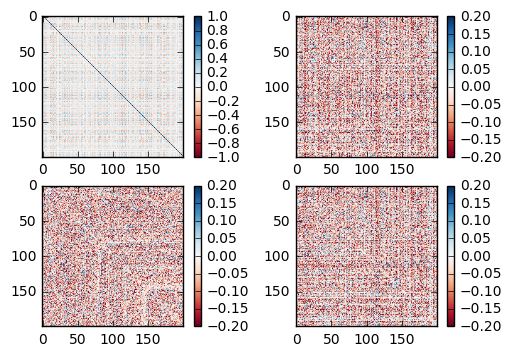

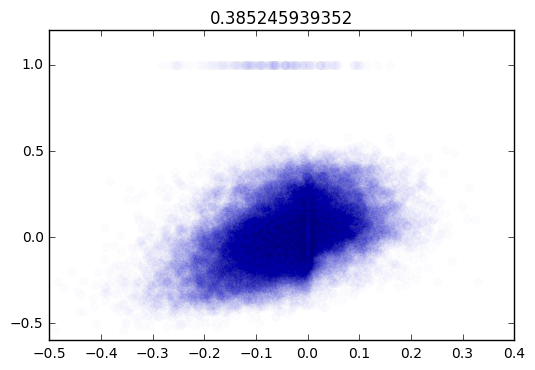

In [239]:
s = np.squeeze(s)
fc = np.corrcoef(s.T)
tril_idx = np.tril(np.ones([200,200]),-1)==1
triu_idx = np.triu(np.ones([200,200]),1)==1

plt.figure()
plt.subplot(2,2,1)
plt.imshow(fc,cmap='RdBu',vmin=-1,vmax=1)
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(w['W_rec'],cmap='RdBu',vmin=-.2,vmax=.2)
plt.colorbar()

plt.subplot(2,2,3)
plt.imshow(squareform(w['W_rec'][tril_idx]),cmap='RdBu',vmin=-.2,vmax=.2)
plt.colorbar()

plt.subplot(2,2,4)
plt.imshow(squareform(w['W_rec'][triu_idx]),cmap='RdBu',vmin=-.2,vmax=.2)
plt.colorbar()

plt.figure()

plt.plot(w['W_rec'].flatten(),fc.flatten(),'o',alpha=.01)
plt.title(np.corrcoef(w['W_rec'].flatten(),fc.flatten())[0,1])

plt.show()

In [524]:
#run with differently timed onset of rule input
start_time = time.time()

tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
n_tasks = len(tasks)
inps = [[0,0],[0,1],[1,0],[1,1]]

mem_gap_length = 200

params['sample_size'] = 1000
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['mem_gap'] = mem_gap_length #40

perturb_times = [150] #range(0,310,5)

w = np.load(weights_path)
wrec = w['W_rec']
e_wrec = (wrec>0).astype('float')
i_wrec = (wrec<0).astype('float')

#perturbation magnitude
s_perturb = 1. #change in state (multiplicative)
r_perturb = 0. #add random vector to state (additive)
e_perturb = 1.#.9 #change in e weights (multiplicative)
i_perturb = 1. #change in i weights (multiplicative)

t_con_scale = 1.1

n_reps = len(perturb_times)
perf = np.zeros([n_tasks,len(inps),n_reps])
acc = np.zeros(n_reps)

for rep in range(n_reps):
    
    generator = mt.generate_train_trials(params)

    e_sim = experimental_Simulator(params, weights_path=weights_path)
    data = generator.next()
    rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
    in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
    in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)
    target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
    
    data[0][:,:perturb_times[rep],2:n_tasks+2] = .1  #turn on context input
#     data[0][:,perturb_times[rep]:,2:n_tasks+2] = .1  #turn off context input
#     data[0][:,perturb_times[rep]:,:2] = 0 #turn off sensory input 2

    s,o = run_perturbation_trial(data,None)

    
    choice = np.argmax(o[-1,:,:],axis=1)
    correct = choice == target
    acc[rep] = np.mean(correct)

    print rep, time.time() - start_time, 'performance = ' + str(acc[rep]*100) + '%', perturb_times[rep]

    # tasks = ['xor','or','and','memory_saccade','direct_report']

    for ii in range(n_tasks):
        for jj in range(len(inps)):
            idx = np.logical_and(np.logical_and(rule==ii,in1 == inps[jj][0]), in2 == inps[jj][1])
            perf[ii,jj,rep] = np.mean(choice[idx]==target[idx])
            

0 45.197245121 performance = 78.1% 150


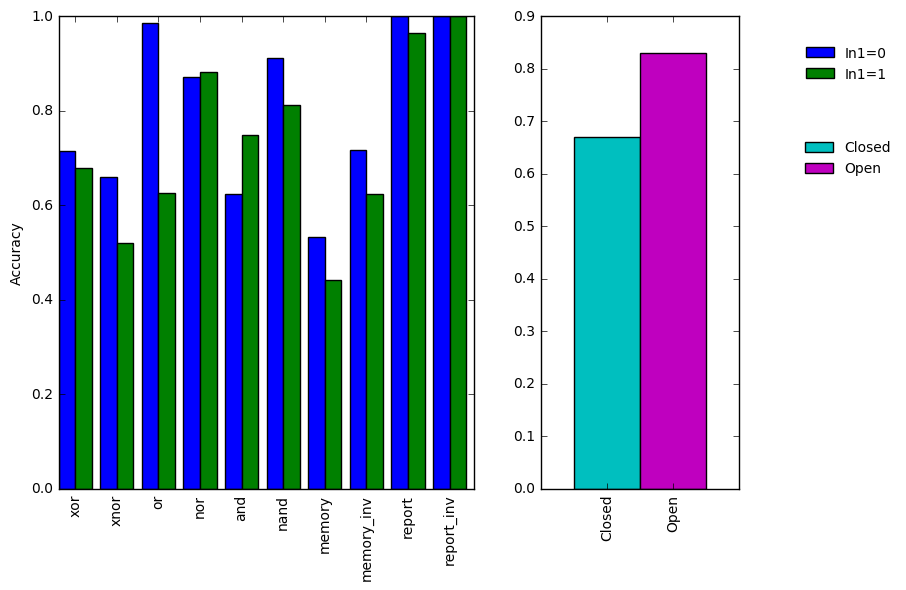

In [370]:
t0 = 0

perf_vec = np.hstack([np.mean(perf[:,:2,t0],axis=1),np.mean(perf[:,2:,t0],axis=1)])
plt.figure(figsize=(10,6))
plt.subplot(1,2,1) 
plt.bar(np.arange(n_tasks),np.mean(perf[:,:2,t0],axis=1),color='b',width=.4)
plt.bar(.4+np.arange(n_tasks),np.mean(perf[:,2:,t0],axis=1),color='g',width=.4)
plt.ylabel('Accuracy')
plt.legend(['In1=0','In1=1'],frameon=False,fontsize=10,loc='center',bbox_to_anchor=[1.895,.9,0,0])
plt.xticks(.4+np.arange(n_tasks),tasks,rotation=90)

plt.subplot(1,4,3)
plt.bar(0,np.mean(perf_vec[closure_vec.flatten()==-1]),color='c',width=.4)
plt.bar(.4,np.mean(perf_vec[closure_vec.flatten()==1]),color='m',width=.4)
plt.legend(['Closed','Open'],frameon=False,fontsize=10,loc='center',bbox_to_anchor=[1.55,.7,0,0])
plt.xticks([.2,.6],['Closed','Open'],rotation=90)
plt.xlim([-.2,1.])

plt.tight_layout()
plt.show()
# closure_vec



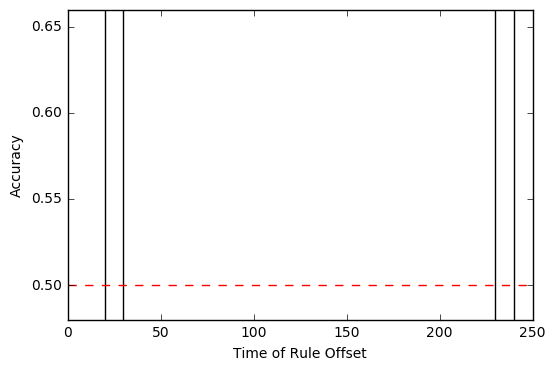

IndexError: index 20 is out of bounds for axis 2 with size 1

In [271]:
plt.plot(perturb_times,acc)
# plt.legend(tasks,fontsize=8,frameon=False,loc='center',bbox_to_anchor=[1.15,.7,0,0])
plt.axvline(params['input_wait'],c='k')
plt.axvline(params['input_wait']+params['stim_dur'],c='k')

plt.axvline(params['input_wait']+params['stim_dur']+params['mem_gap'],c='k')
plt.axvline(params['input_wait']+2*params['stim_dur']+params['mem_gap'],c='k')

plt.axhline(.5,c='r',linestyle='--')
plt.xlabel('Time of Rule Offset')
plt.ylabel('Accuracy')
plt.show()

perf[:,:,20]

In [104]:
#run with random weight perturbations
start_time = time.time()

tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
n_tasks = len(tasks)
inps = [[0,0],[0,1],[1,0],[1,1]]

mem_gap_length = 200

params['sample_size'] = 200
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['mem_gap'] = mem_gap_length #40

perturb_time = 200

w = np.load(weights_path)
wrec = w['W_rec']
e_wrec = (wrec>0).astype('float')
i_wrec = (wrec<0).astype('float')

#perturbation magnitude
s_perturb = 1. #change in state (multiplicative)
r_perturb = 0. #add random vector to state (additive)
e_perturb = 1.#.9 #change in e weights (multiplicative)
i_perturb = 1. #change in i weights (multiplicative)

t_con_scale = 1.1

n_reps = 1000
perf = np.zeros([n_tasks,len(inps),n_reps])
t_con_array = []

for rep in range(n_reps):
    t_connectivity = np.exp(t_con_scale*np.random.randn(wrec.shape[0],wrec.shape[1])) #[e_perturb*e_wrec + i_perturb*i_wrec]*1000
#     t_connectivity = np.random.choice([0,1],replace=True,size=(wrec.shape[0],wrec.shape[1]),p=[.5,.5])
    t_con_array.append(t_connectivity)
    
    generator = mt.generate_train_trials(params)

    e_sim = experimental_Simulator(params, weights_path=weights_path)
    data = generator.next()

    s,o = run_perturbation_trial(data,t_connectivity)

    in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
    in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

    rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
    choice = np.argmax(o[-1,:,:],axis=1)
    target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
    correct = choice == target

    print rep, time.time() - start_time, 'performance = ' + str(np.mean(correct)*100) + '%'

    # tasks = ['xor','or','and','memory_saccade','direct_report']

    for ii in range(n_tasks):
        for jj in range(len(inps)):
            idx = np.logical_and(np.logical_and(rule==ii,in1 == inps[jj][0]), in2 == inps[jj][1])
            perf[ii,jj,rep] = np.mean(choice[idx]==target[idx])
            

# plt.figure(figsize=(8,3))
# plt.subplot(1,2,1)
# plt.imshow(perf,interpolation='none',vmin=0,vmax=1,cmap='RdBu')
# plt.colorbar()
# plt.xticks(np.arange(0,4),inps,rotation=90)
# plt.yticks(range(10),tasks)

# plt.subplot(2,2,2)
# plt.plot(s[:,rule==0,:][:,0,:],alpha=.2)

# plt.subplot(2,2,4)
# plt.plot(o[:,rule==0,:][:,0,:],alpha=1.)

# plt.tight_layout()
# plt.show()

0 10.1745820045 performance = 73.0%
1 19.6844689846 performance = 70.0%
2 29.1983168125 performance = 69.5%
3 38.9257798195 performance = 71.0%
4 49.4741919041 performance = 66.5%
5 58.8316659927 performance = 69.5%
6 68.4154188633 performance = 69.5%
7 77.8838489056 performance = 74.5%
8 87.4144508839 performance = 71.0%
9 96.9175858498 performance = 65.5%
10 106.409119844 performance = 76.5%
11 115.917671919 performance = 72.5%
12 125.381756783 performance = 68.5%
13 134.87566781 performance = 65.5%
14 144.357221842 performance = 70.0%
15 153.848315954 performance = 69.5%
16 163.296952963 performance = 73.5%
17 172.72316885 performance = 67.5%
18 182.164175987 performance = 67.5%
19 191.766866922 performance = 66.5%
20 201.373594999 performance = 73.0%
21 211.949880838 performance = 72.5%
22 225.626470804 performance = 71.0%
23 236.884981871 performance = 73.5%
24 248.18956995 performance = 76.5%
25 259.513876915 performance = 68.5%
26 270.250508785 performance = 73.0%
27 280.9092788

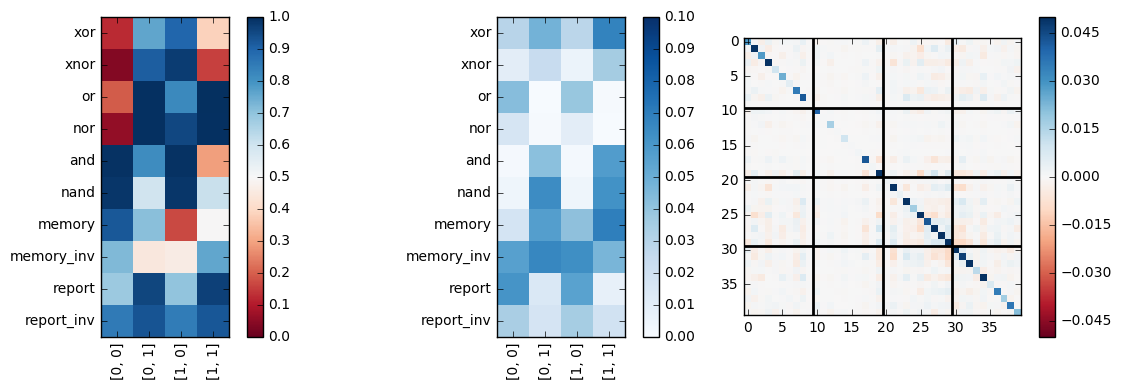

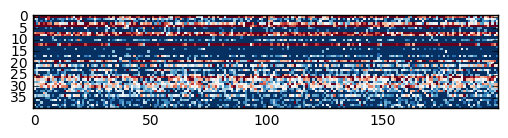

(10, 4, 1000)

In [105]:
#clean up nans
nan_idx = np.isnan(np.mean(np.mean(perf,axis=0),axis=0))

perf_vec = np.zeros([n_reps,n_tasks*4])
for ii in range(n_reps):
    perf_vec[ii,:] = perf[:,:,ii].flatten()
    perf_vec[ii,np.isnan(perf_vec[ii,:])] = np.nanmean(perf_vec[ii,:])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(np.nanmean(perf,axis=2),interpolation='none',cmap='RdBu',vmin=0,vmax=1)
plt.colorbar()
plt.xticks(np.arange(0,4),inps,rotation=90)
plt.yticks(range(10),tasks)

plt.subplot(1,3,2)
plt.imshow(np.nanvar(perf,axis=2),interpolation='none',cmap='Blues',vmin=0,vmax=.1)
plt.colorbar()
plt.xticks(np.arange(0,4),inps,rotation=90)
plt.yticks(range(10),tasks)

plt.subplot(1,3,3)
plt.imshow(np.cov(perf_vec[~nan_idx,:].T),interpolation='none',cmap='RdBu',vmin=-.05,vmax=.05)
plt.axvline(9.5,c='k',linewidth=2)
plt.axhline(9.5,c='k',linewidth=2)

plt.axvline(19.5,c='k',linewidth=2)
plt.axhline(19.5,c='k',linewidth=2)

plt.axvline(29.5,c='k',linewidth=2)
plt.axhline(29.5,c='k',linewidth=2)
plt.colorbar()

plt.tight_layout()

plt.figure()
plt.imshow(perf_vec[:200,:].T,interpolation='none',cmap='RdBu',vmin=0,vmax=1)
plt.show()

perf.shape

200


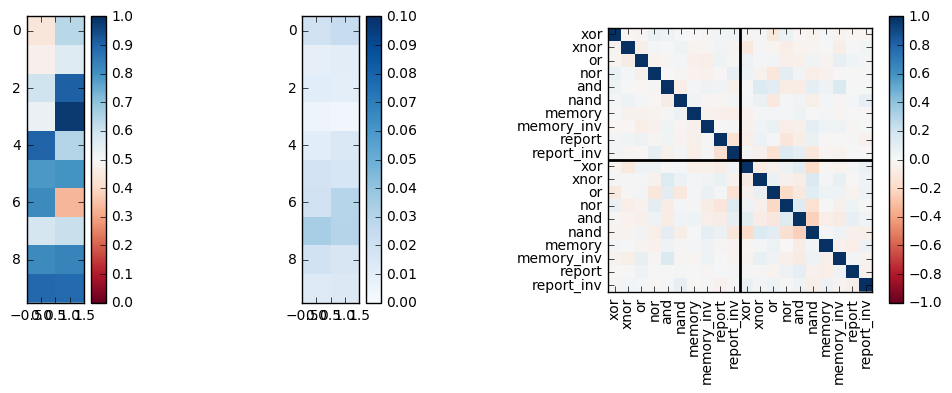

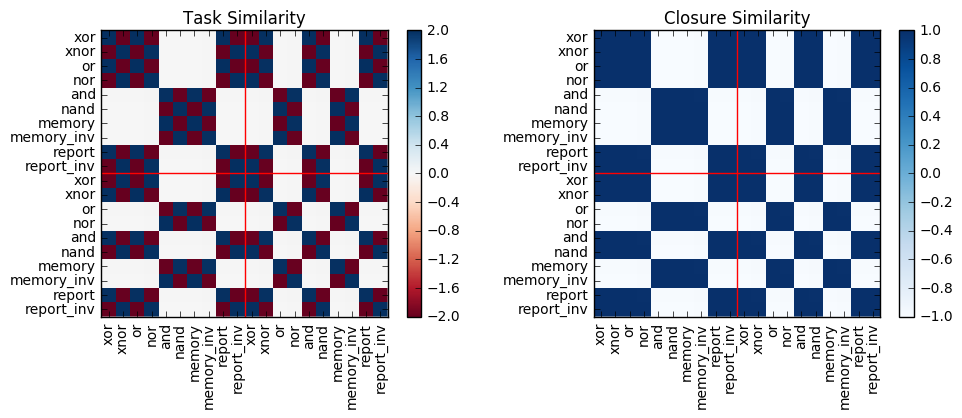

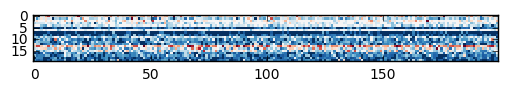

0

In [112]:
perf_in1 = np.zeros([10,2,n_reps])
perf_in1[:,0,:] = np.sum(perf[:,:2,:],axis=1)/2.
perf_in1[:,1,:] = np.sum(perf[:,2:,:],axis=1)/2.


nan_idx = np.isnan(np.mean(np.mean(perf_in1,axis=0),axis=0))
print np.sum(nan_idx)

perf_in1_vec = np.zeros([n_reps,n_tasks*2])
for ii in range(n_reps):
    perf_in1_vec[ii,:] = perf_in1[:,:,ii].flatten()
    perf_in1_vec[ii,np.isnan(perf_in1_vec[ii,:])] = np.nanmean(perf_in1_vec[ii,:])

plt.figure(figsize=(10,4))
plt.subplot(1,4,1)
plt.imshow(np.nanmean(perf_in1,axis=2),interpolation='none',cmap='RdBu',vmin=0,vmax=1.)
plt.colorbar()


plt.subplot(1,4,2)
plt.imshow(np.nanvar(perf_in1,axis=2),interpolation='none',cmap='Blues',vmin=0,vmax=.1)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(np.corrcoef(perf_in1_vec[~nan_idx,:].T),interpolation='none',cmap='RdBu',vmin=-1.,vmax=1.)
plt.axvline(9.5,c='k',linewidth=2)
plt.axhline(9.5,c='k',linewidth=2)
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')

plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Task Similarity')
plt.imshow(all_resp_mat.dot(all_resp_mat.T),interpolation='none',cmap='RdBu')
plt.colorbar()
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')

plt.subplot(1,2,2)
plt.title('Closure Similarity')
plt.imshow(closure_vec.dot(closure_vec.T),interpolation='none',cmap='Blues')
plt.colorbar()
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')

plt.tight_layout()


plt.figure()
plt.imshow(perf_in1_vec[:200,:].T,interpolation='none',cmap='RdBu',vmin=0,vmax=1)
plt.show()



np.sum(np.isnan(perf_in1_vec))


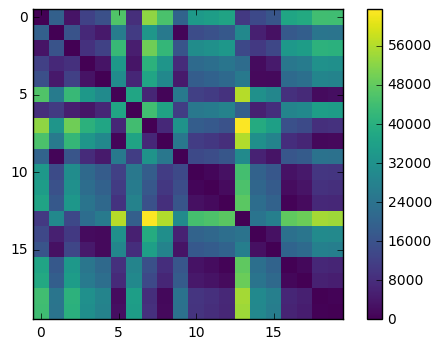

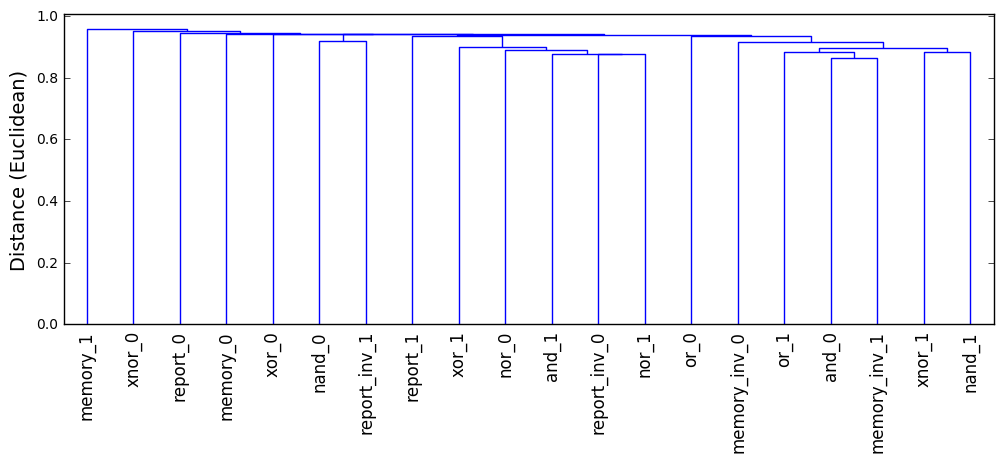

In [110]:
T = np.asarray(t_con_array)
# perf[0:1,0,:].dot(T)
mat = T.T.dot(perf_in1_vec)

dist = np.zeros([20,20])
for ii in range(20):
    for jj in range(20):
        dist[ii,jj] = np.sqrt(np.sum((mat[:,:,ii]-mat[:,:,jj])**2))
        
plt.imshow(dist,interpolation='none')
plt.colorbar()


plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# ytdist = pdist(fr_all.T,metric='euclidean')

# d_condensed = (1-np.corrcoef(perf_in1_vec[~nan_idx,:].T))[np.triu(np.ones([20,20]),1)==1]
d_condensed = pdist(perf_in1_vec.T,metric='correlation')


Z = hierarchy.linkage(d_condensed, 'single')
dn = hierarchy.dendrogram(Z,labels=[t_+'_0' for t_ in tasks]+[t_+'_1' for t_ in tasks],leaf_rotation=90)
plt.ylabel('Distance (Euclidean)',fontsize=14)
plt.show()

In [101]:
np.random.choice([0,1],replace=True,size=(200,200),p=[.1,.9])

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 0],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [243]:
#run with memory perturbation (loss of working memory state)

mem_gap_length = 200

params['sample_size'] = 100
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['mem_gap'] = mem_gap_length #40

perturb_time = 200

w = np.load(weights_path)
wrec = w['W_rec']
e_wrec = (wrec>0).astype('float')
i_wrec = (wrec<0).astype('float')

#perturbation magnitude
s_perturb = 0. #change in state (multiplicative)
r_perturb = 0. #add random vector to state (additive)
e_perturb = 1.#.9 #change in e weights (multiplicative)
i_perturb = 1. #change in i weights (multiplicative)

t_connectivity = [e_perturb*e_wrec + i_perturb*i_wrec]*1000

generator = mt.generate_train_trials(params)

e_sim = experimental_Simulator(params, weights_path=weights_path)
data = generator.next()

init = None #200*np.random.randn(1,200)
# e_sim.run_trial(data[0][0,:,:],init=init)


s = np.zeros([data[0].shape[1],data[0].shape[0],w['W_rec'].shape[0]])

for kk in range(data[0].shape[0]):
    #pre perturbation
    s[:perturb_time,kk,:] = e_sim.run_trial(data[0][kk,:perturb_time,:],t_connectivity=t_connectivity,init=None)[1].reshape([perturb_time,w['W_rec'].shape[0]])
    #perturbation
    init = s[perturb_time-1,kk,:].reshape([1,200])
    init = init*s_perturb
    init += r_perturb*np.random.randn(1,200)/np.sqrt(200)
    #post perturbation
    s[perturb_time:,kk,:] = e_sim.run_trial(data[0][kk,perturb_time:,:],t_connectivity=t_connectivity,init=init)[1].reshape([data[0].shape[1]-perturb_time,w['W_rec'].shape[0]])

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)


tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
n_tasks = len(tasks)
inps = [[0,0],[0,1],[1,0],[1,1]]

in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
choice = np.argmax(o[-1,:,:],axis=1)
target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
correct = choice == target

print 'performance = ' + str(np.mean(correct)*100) + '%'

# tasks = ['xor','or','and','memory_saccade','direct_report']


performance = 70.2%


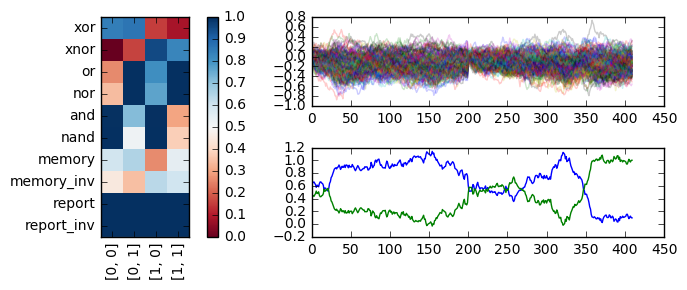

In [45]:
perf = np.zeros([n_tasks,len(inps)])
for ii in range(n_tasks):
    for jj in range(len(inps)):
        idx = np.logical_and(np.logical_and(rule==ii,in1 == inps[jj][0]), in2 == inps[jj][1])
        perf[ii,jj] = np.mean(choice[idx]==target[idx])

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.imshow(perf,interpolation='none',vmin=0,vmax=1,cmap='RdBu')
plt.colorbar()
plt.xticks(np.arange(0,4),inps,rotation=90)
plt.yticks(range(10),tasks)

plt.subplot(2,2,2)
plt.plot(s[:,rule==0,:][:,0,:],alpha=.2)

plt.subplot(2,2,4)
plt.plot(o[:,rule==0,:][:,0,:],alpha=1.)

plt.tight_layout()
plt.show()

In [42]:
#parameter sweep: run with memory perturbation (e/i balance)

start = time.time()

mem_gap_length = 100

params['sample_size'] = 1000
params['rec_noise'] = .1#.1
params['stim_noise'] = .0#.1
params['mem_gap'] = mem_gap_length #40
params['trial_proportion'] = 'balanced'

perturb_time = 80

w = np.load(weights_path)
wrec = w['W_rec']
e_wrec = (wrec>0).astype('float')
i_wrec = (wrec<0).astype('float')

#timed perturbations
s_perturb = 1. #change in state (multiplicative)
r_perturb = 0. #add random vector to state (additive)


generator = mt.generate_train_trials(params)
e_sim = experimental_Simulator(params, weights_path=weights_path)
data = generator.next()

excs = np.linspace(.5,2.,19) #[.9,.95,1.,1.05,1.1]
inhs = np.linspace(.5,2.,19) #[.9,.95,1,1.05,1.1]

perf = np.zeros([len(excs),len(inhs),n_tasks,len(inps)])
mu_rate = np.zeros([len(excs),len(inhs),wrec.shape[0]])
sigma_rate = np.zeros([len(excs),len(inhs),wrec.shape[0]])

for ee,exc in enumerate(excs):
    for ii,inh in enumerate(inhs):
        

        #weight perturbations
        e_perturb = exc #change in e weights (multiplicative)
        i_perturb = inh #change in i weights (multiplicative)
        t_connectivity = [e_perturb*e_wrec + i_perturb*i_wrec]*1000

        #initalization
        init = None

        #run trials
        s = np.zeros([data[0].shape[1],data[0].shape[0],w['W_rec'].shape[0]])
        for steps in range(data[0].shape[0]):
            #pre perturbation
            s[:perturb_time,steps,:] = e_sim.run_trial(data[0][steps,:perturb_time,:],t_connectivity=t_connectivity,init=None)[1].reshape([perturb_time,w['W_rec'].shape[0]])
            #perturbation
            init = s[perturb_time-1,steps,:].reshape([1,N_rec])
            init = init*s_perturb
            init += r_perturb*np.random.randn(1,N_rec)/np.sqrt(N_rec)
            #post perturbation
            s[perturb_time:,steps,:] = e_sim.run_trial(data[0][steps,perturb_time:,:],t_connectivity=t_connectivity,init=init)[1].reshape([data[0].shape[1]-perturb_time,w['W_rec'].shape[0]])

        o = np.zeros([s.shape[0],s.shape[1],n_out])
        for o_steps in range(data[0].shape[0]):
            o[:,o_steps,:] = state_to_out(s[:,o_steps,:],w)


        tasks = ['xor','xnor','or','nor','and','nand','memory','memory_inv','report','report_inv']
        n_tasks = len(tasks)
        inps = [[0,0],[0,1],[1,0],[1,1]]

        in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
        in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

        rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
        choice = np.argmax(o[-1,:,:],axis=1)
        target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
        correct = choice == target
        
        mu_rate[ee,ii,:] = np.mean(np.mean(relu(s),axis=1),axis=0)
        sigma_rate[ee,ii,:] = np.mean(np.std(relu(s),axis=1),axis=0)

        
        for jj in range(n_tasks):
            for kk in range(len(inps)):
                idx = np.logical_and(np.logical_and(rule==jj,in1 == inps[kk][0]), in2 == inps[kk][1])
                perf[ee,ii,jj,kk] = np.mean(choice[idx]==target[idx])
                
        print exc,inh, ' - ' + str(np.round(time.time()-start,decimals=2)) + ' secs - ', 'acc = ' + str(np.round(np.mean(perf[ee,ii,:,:],axis=1),decimals=2))

0.5 0.5  - 39.28 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 0.583333333333  - 78.07 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 0.666666666667  - 117.03 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 0.75  - 156.0 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 0.833333333333  - 194.79 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 0.916666666667  - 233.25 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 1.0  - 272.04 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 1.08333333333  - 310.75 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 1.16666666667  - 349.57 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 1.25  - 388.23 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5 1.33333333333  - 426.87 secs -  acc = [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan]
0.5

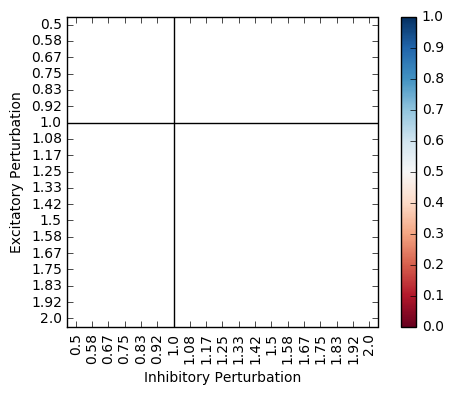

In [43]:
# plt.imshow(np.mean(np.mean(perf,axis=3),axis=2),interpolation='none',vmin=0,vmax=1,cmap='RdBu')

plt.imshow(np.mean(perf[:,:,9,:],axis=2),interpolation='none',vmin=0,vmax=1,cmap='RdBu')
plt.yticks(range(len(excs)),np.round(excs,decimals=2))
plt.ylabel('Excitatory Perturbation')
plt.xticks(range(len(inhs)),np.round(excs,decimals=2),rotation=90)
plt.xlabel('Inhibitory Perturbation')
plt.colorbar()

plt.axvline(np.where(inhs==1),color='k')
plt.axhline(np.where(excs==1),color='k')
plt.show()

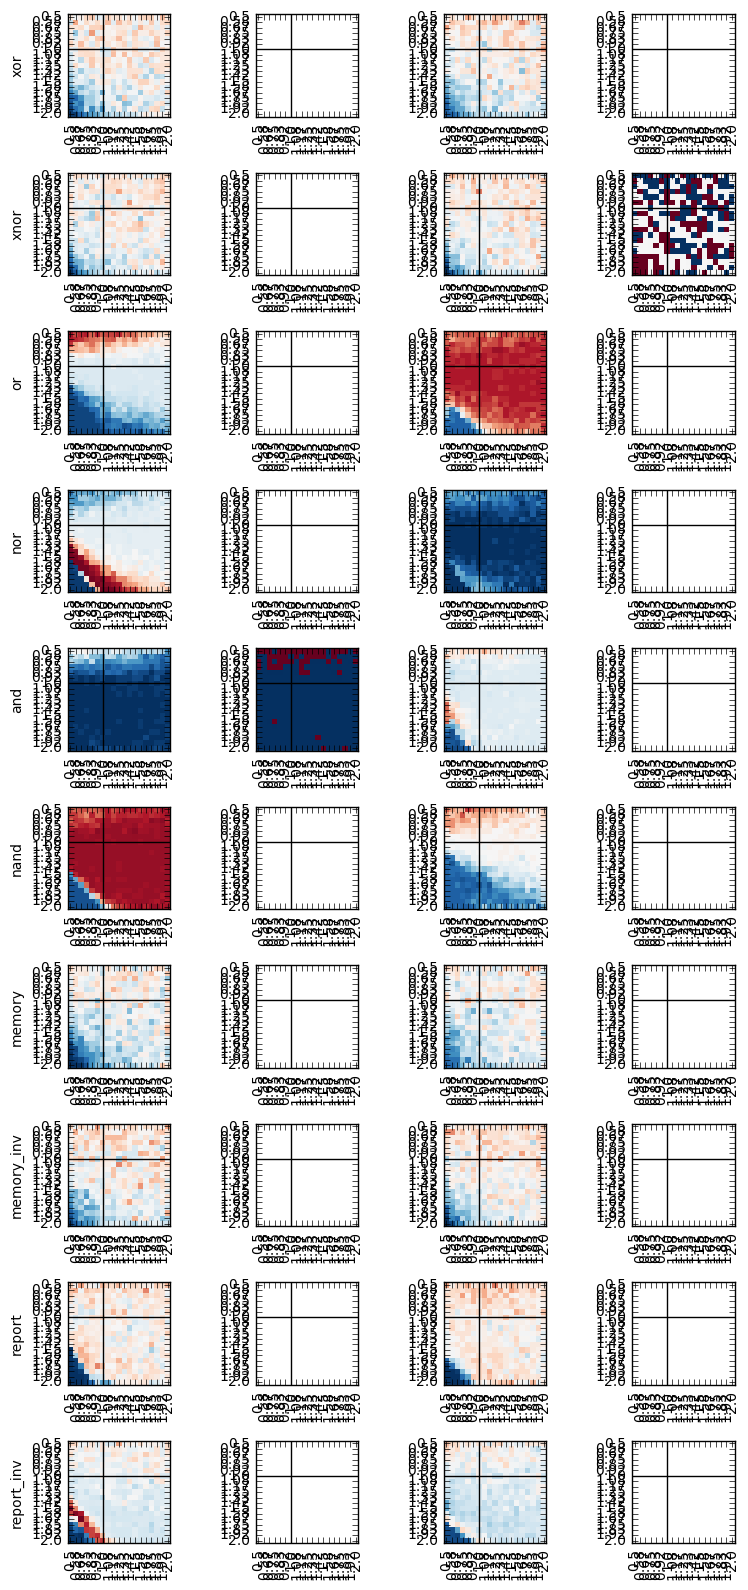

In [44]:
loc_1 = np.where(inhs==1)[0][0]

plt.figure(figsize=(8,16))
count = 1
for jj in range(n_tasks):
    for ii in range(len(inps)):
        plt.subplot(n_tasks,len(inps),count)
        plt.imshow(perf[:,:,jj,ii],interpolation='none',vmin=0,vmax=1,cmap='RdBu')
        plt.yticks(range(len(excs)),np.round(excs,decimals=2))
#         plt.ylabel('Excitatory Perturbation')
        plt.xticks(range(len(inhs)),np.round(excs,decimals=2),rotation=90)
        plt.axvline(np.where(inhs==1),color='k')
        plt.axhline(np.where(excs==1),color='k')
        if ii == 0:
            plt.ylabel(tasks[jj])
#         plt.title(inps[ii])
#         plt.colorbar(shrink=.6)
        
        count+= 1
plt.tight_layout()

plt.show()

# t = input_wait+stim_dur+mem_gap_length+1
# t

# # plt.plot(data[0][0,:,:])
# # plt.axvline(t,c='k')

# plt.plot(data[0][:,t,:].T)
# plt.show()



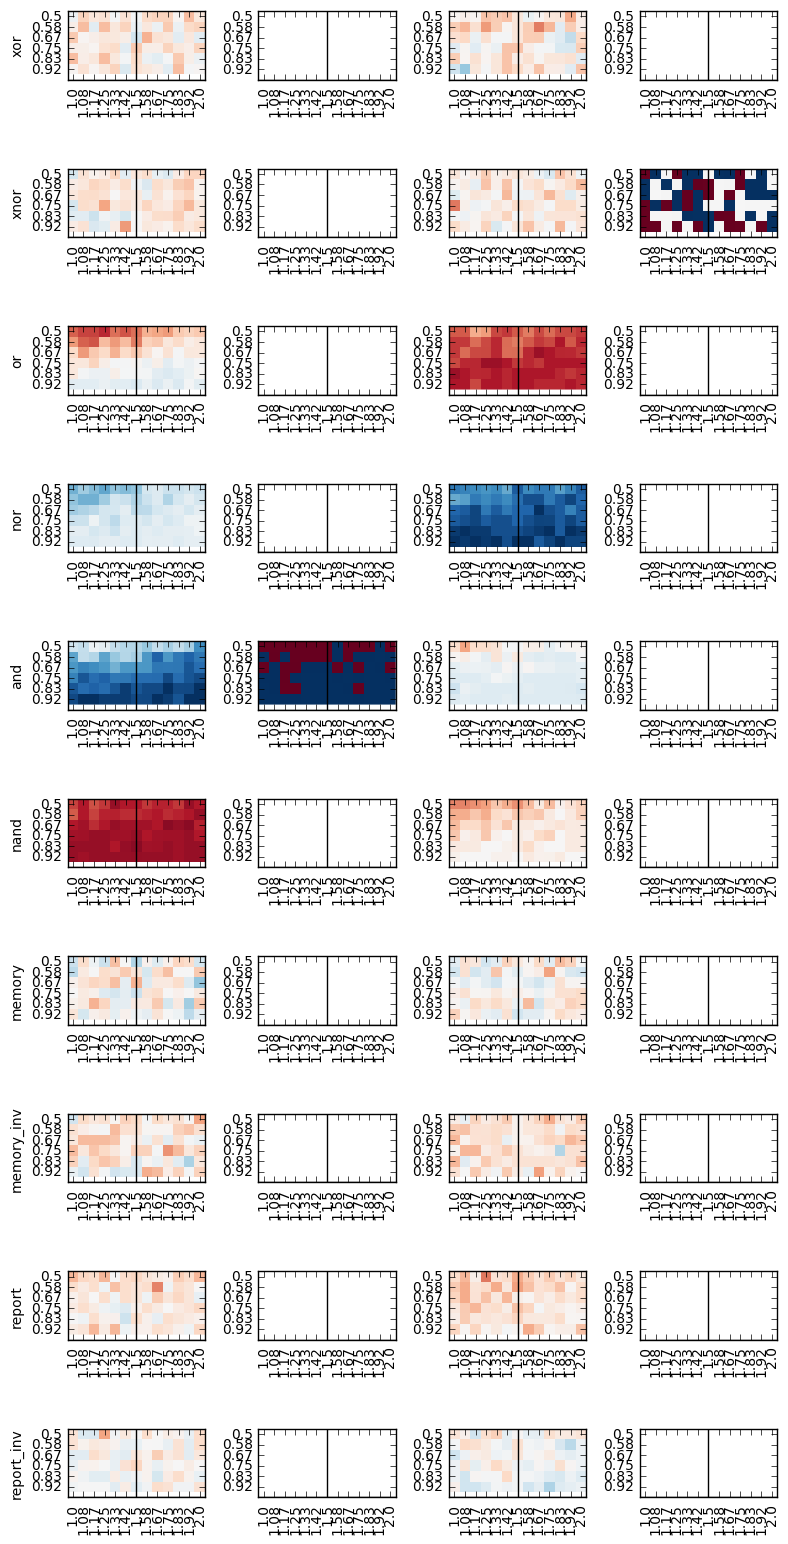

In [45]:
loc_1 = np.where(inhs==1)[0][0]

plt.figure(figsize=(8,16))
count = 1
for jj in range(n_tasks):
    for ii in range(len(inps)):
        plt.subplot(n_tasks,len(inps),count)
        plt.imshow(perf[:loc_1,loc_1:,jj,ii],interpolation='none',vmin=0,vmax=1,cmap='RdBu')
        plt.yticks(range(loc_1),np.round(excs[:loc_1],decimals=2))
#         plt.ylabel('Excitatory Perturbation')
        plt.xticks(range(len(inhs)-loc_1),np.round(inhs[loc_1:],decimals=2),rotation=90)
        plt.axvline(np.where(inhs==1),color='k')
        plt.axhline(np.where(excs==1),color='k')
        if ii == 0:
            plt.ylabel(tasks[jj])
#         plt.title(inps[ii])
#         plt.colorbar(shrink=.6)
        
        count+= 1
plt.tight_layout()

plt.show()


In [46]:
#run trials with rule algebra

# w = np.load(weights_path)

# #test params
# cohs = [.02]
# params['sample_size'] = 500
# params['rec_noise'] = .0#.1
# params['stim_noise'] = .0#.1

# params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
#                     stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
#                     L2_firing_rate = 0, sample_size = sample_size, epochs = 100, N_rec = n_hidden, 
#                     dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = mt.generate_train_trials(params)

sim = Simulator(params, weights_path=weights_path)

data = generator.next()

#rule = nor-or+and
data[0][:,:,2:n_tasks+2] *= .0
data[0][:,:,2] = 0. #xor
data[0][:,:,3] = 0. #xnor
data[0][:,:,4] = 0.#or
data[0][:,:,5] = 0. #nor
data[0][:,:,6] = 0.#and
data[0][:,:,7] = 0 #nand
data[0][:,:,8] = 0 #ms
data[0][:,:,8] = 0 #ms_inv
data[0][:,:,8] = 0 #dr
data[0][:,:,8] = 0  #dr_inv


# plt.plot(data[0][:,20,:].T)
# plt.ylim([-1.1,1.1])
# plt.show()

s = run_trial_batch(data,w,sim)

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)


in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

target = (in1+in2<1).astype('int')
choice = np.argmax(o[-1,:,:],axis=1)

print np.mean(choice==target)

0.498


performance = 53.2%
xor performance = 53.2%
xnor performance = nan%
or performance = nan%
nor performance = nan%
and performance = nan%
nand performance = nan%
memory performance = nan%
memory_inv performance = nan%
report performance = nan%
report_inv performance = nan%


ValueError: x and y must have same first dimension

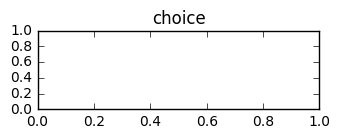

In [47]:
#run trials with rule input disruption during encoding

# w = np.load(weights_path)

# #test params
# cohs = [.02]
# params['sample_size'] = 500
# params['rec_noise'] = .0#.1
# params['stim_noise'] = .0#.1

# params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
#                     stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
#                     L2_firing_rate = 0, sample_size = sample_size, epochs = 100, N_rec = n_hidden, 
#                     dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = mt.generate_train_trials(params)

sim = Simulator(params, weights_path=weights_path)

data = generator.next()

#disruption after stim1 encoding
data[0][:,:60,2:n_tasks+2] *= .0

s = run_trial_batch(data,w,sim)

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)
    
    
in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
choice = np.argmax(o[-1,:,:],axis=1)
target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
correct = choice == target

print 'performance = ' + str(np.mean(correct)*100) + '%'

# tasks = ['xor','or','and','memory_saccade','direct_report']

for ii in range(n_tasks):
    
    print tasks[ii] + ' performance = ' + str(100*np.mean(choice[rule==ii]==target[rule==ii])) + '%'
 
#task analysis
# tasks = ['xor','or','and','memory_saccade','direct_report']

div1 =  rule
div2 = choice

plt.figure(figsize=(8,12))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+1)
    if ii ==0:
        plt.title('choice')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
    plt.ylabel(tasks[ii])
   
    
div1 =  rule
div2 = in1

# plt.figure(figsize=(6,7))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+2)
    if ii ==0:
        plt.title('stim1')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)

#     plt.ylim([-.4,.4])
    
# plt.legend(tasks,fontsize=8)
    
plt.tight_layout()
plt.show()

# data[0].shape

In [ ]:
#run trials with rule input disruption after encoding

# w = np.load(weights_path)

# #test params
# cohs = [.02]
# params['sample_size'] = 500
# params['rec_noise'] = .0#.1
# params['stim_noise'] = .0#.1

# params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
#                     stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
#                     L2_firing_rate = 0, sample_size = sample_size, epochs = 100, N_rec = n_hidden, 
#                     dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = mt.generate_train_trials(params)

sim = Simulator(params, weights_path=weights_path)

data = generator.next()

#disruption after stim1 encoding
data[0][:,60:,2:n_tasks+2] *= .0

s = run_trial_batch(data,w,sim)

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)
    
    
in1 = np.argmax(data[0][:,input_wait+1,:2],axis=1)
in2 = np.argmax(data[0][:,input_wait+stim_dur+mem_gap_length+1,:2],axis=1)

rule = np.argmax(data[0][:,0,2:n_tasks+2],axis=1)
choice = np.argmax(o[-1,:,:],axis=1)
target = np.argmax(data[1][:,input_wait+2*stim_dur+mem_gap_length+out_gap+10,:],axis=1)
correct = choice == target

print 'performance = ' + str(np.mean(correct)*100) + '%'

# tasks = ['xor','or','and','memory_saccade','direct_report']

for ii in range(n_tasks):
    
    print tasks[ii] + ' performance = ' + str(100*np.mean(choice[rule==ii]==target[rule==ii])) + '%'
 
#task analysis
# tasks = ['xor','or','and','memory_saccade','direct_report']

div1 =  rule
div2 = choice

plt.figure(figsize=(8,12))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+1)
    if ii ==0:
        plt.title('choice')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)
    plt.ylabel(tasks[ii])
   
    
div1 =  rule
div2 = in1

# plt.figure(figsize=(6,7))
for ii in range(n_tasks):
    plt.subplot(n_tasks,2,2*ii+2)
    if ii ==0:
        plt.title('stim1')
    plt.plot(tt,np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==0),:],0),axis=1)-np.mean(np.maximum(s[:,np.logical_and(div1==ii,div2==1),:],0),axis=1),alpha=1)
#     plt.plot(np.mean(np.maximum(s[:,np.logical_and(rule==ii,in1==1),:],0),axis=1),alpha=1)

#     plt.ylim([-.4,.4])
    
# plt.legend(tasks,fontsize=8)
    
plt.tight_layout()
plt.show()

In [ ]:
for ii in range(n_tasks):
    plt.subplot(n_tasks,1,ii+1)
    plt.plot(s[:,:,ii],'b',alpha=.01)
plt.show()

In [ ]:
plt.hist(np.mean(s[150:200,:,:]>0,axis=1).flatten(),50)
# plt.colorbar()
    
plt.show()

In [ ]:
plt.plot(np.mean(s[150,np.logical_and(in1==0,rule<12),:]>0,axis=0),np.mean(s[150,np.logical_and(in1==1,rule<12),:]>0,axis=0),'o',alpha=.5)

plt.title('Neurons by pct active sessions \n(4 memory tasks)')
plt.ylabel('pct sessions active during memory (stim1=1)')
plt.xlabel('pct sessions active during memory (stim1=0)')

plt.ylim([-.1,1.1])
plt.xlim([-.1,1.1])
plt.yticks(np.arange(0,1.1,.25))
plt.xticks(np.arange(0,1.1,.25))
plt.axes().set_aspect('equal')
plt.grid()
plt.show()

In [ ]:
t/60.


In [ ]:
#example outputs by condition and in1

plt.figure(figsize=(10,4))
for jj in range(n_tasks):
    task_num = jj
    plt.subplot(2,5,jj+1)
    colors = ['c','m']
    for ii in range(20):
        trial_idx = np.where(rule==task_num)[0][ii]
        o = state_to_out(s[:,trial_idx,:],w)
#         plt.plot(tt,o[:,0],colors[in1[trial_idx]])
        plt.plot(tt,o[:,1],colors[in1[trial_idx]])
        plt.title(tasks[task_num])

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='c', lw=2),
                Line2D([0], [0], color='m', lw=2),]

plt.legend(custom_lines,['in1=0','in1=1'],frameon=False,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:620: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)


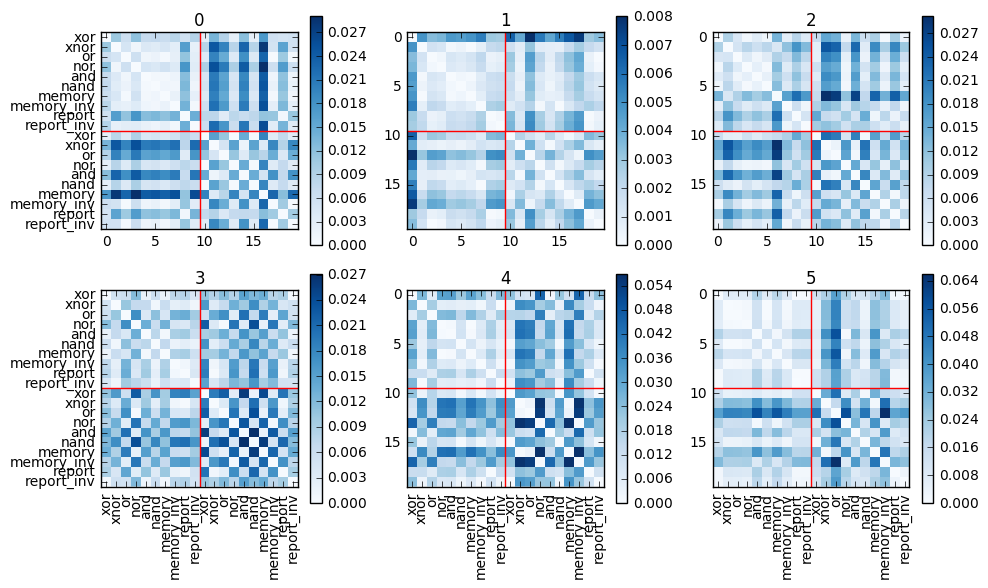

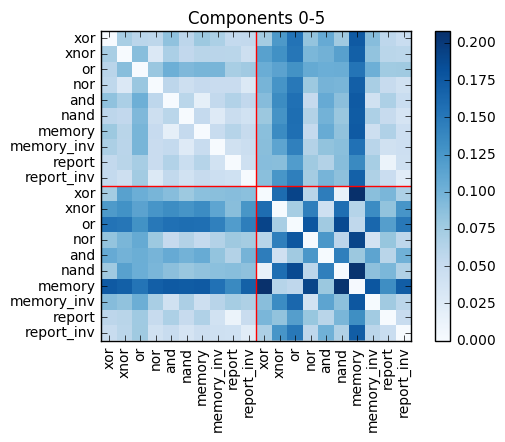

In [96]:
#task similarity by pc components
from scipy.spatial.distance import pdist,squareform
plt.figure(figsize=(10,6))
for ii in range(6):
    plt.subplot(2,3,ii+1)
    plt.title(ii)
    plt.imshow(squareform(pdist(pcs_rule.dot(fr_all)[ii:ii+1,:].T)),interpolation='none',cmap='Blues')
    plt.colorbar()
    if ii == 0 or ii == 3:
        plt.yticks(range(20),tasks*2)
    if ii>2:
        plt.xticks(range(20),tasks*2,rotation='vertical')
    plt.axvline(9.5,c='r')
    plt.axhline(9.5,c='r')

plt.tight_layout()

plt.figure()
plt.imshow(squareform(pdist(pcs_rule.dot(fr_all)[:16,:].T)),interpolation='none',cmap='Blues')
plt.colorbar()
plt.axvline(9.5,c='r')
plt.axhline(9.5,c='r')
plt.yticks(range(20),tasks*2)
plt.xticks(range(20),tasks*2,rotation='vertical')
plt.title('Components 0-5')
    
plt.show()
# fr_all.shape